# Forcasting  

In this notebook we will predict the closing prices for the next month

In [ ]:
"""# Import Libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
from copy import deepcopy

# Load the dataset
data = pd.read_csv('./data/cleaned_weekly_stock_market.csv')


# Extract rows for specified companies
companies = ['AMEN BANK', 'ARTES', 'ASSAD', 'BIAT', 'BANQUE DE TUNISIE', 'EURO-CYCLES',
             'SOTUMAG', 'ONE TECH', 'SAH', 'SFBT', 'SOMOCER', 'SOTETEL',
             'SOTUVER', 'TUNISAIR', 'BANQUE ATTIJARI DE TUNIS', 'TELNET HOLDING', 'TPR', 'UIB']

data_filtered = data[data['companyName'].isin(companies)]

def str_to_datetime(s):
    try:
        return datetime.strptime(s, '%Y-%m-%d')
    except ValueError:
        return datetime.strptime(s, '%d/%m/%Y')
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    # Convert string dates to datetime objects
    first_date = str_to_datetime(first_date_str)
    last_date = str_to_datetime(last_date_str)
    target_date = first_date

    dates = []
    X, Y = [], []
    last_time = False

    while not last_time:
        # Select the subset of data up to and including the target date
        df_subset = dataframe.loc[:target_date].tail(n+1)
        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return
        
        # Extract closing prices as features (X) and target (Y)
        values = df_subset['closingPrice'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        # Attempt to move to the next date within a week
        next_week = dataframe.loc[target_date + timedelta(days=1):target_date + timedelta(days=7)]
        if not next_week.empty:
            next_date = next_week.index[0]
        else:
            print("No more data available for the next week.")
            break

        # Update target_date
        target_date = next_date

        # Check if the process should terminate
        if target_date >= last_date:
            last_time = True

    # Prepare the return DataFrame
    ret_df = pd.DataFrame({'Target Date': dates})
    X = np.array(X)
    for i in range(n):
        ret_df[f'Target-{n-i}'] = X[:, i]
    ret_df['Target'] = Y

    return ret_df


def windowed_df_to_date_X_y(windowed_df):
    df_as_np = windowed_df.to_numpy()
    dates = df_as_np[:, 0]
    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape(len(dates), middle_matrix.shape[1], 1)
    y = df_as_np[:, -1]
    return dates, X.astype(np.float32), y.astype(np.float32)

def train_and_plot_model(data, company_name):
    try:
        print(f"Starting process for {company_name}...")
        n = 3 
        df = data[['date', 'closingPrice']]
        df['date'] = df['date'].apply(str_to_datetime) 
        df.index = df.pop('date')
        
        first_valid_date = df.index[n]
        last_date = df.index[-1]
        windowed_df = df_to_windowed_df(df, first_valid_date.strftime('%Y-%m-%d'), last_date.strftime('%Y-%m-%d'), n=n)
        
        if windowed_df is None:
            print("Windowed dataframe is None, exiting...")
            return

        dates, X, y = windowed_df_to_date_X_y(windowed_df)

        print("Splitting data into train, validation, and test sets...")
       # Define the split indices
        q_10 = int(len(dates) * 0.1)
        q_20 = int(len(dates) * 0.2)

        # Split the data
        dates_test, X_test, y_test = dates[:q_10], X[:q_10], y[:q_10]
        dates_val, X_val, y_val = dates[q_10:q_20], X[q_10:q_20], y[q_10:q_20]
        dates_train, X_train, y_train = dates[q_20:], X[q_20:], y[q_20:]


        # Plot the data
        plt.figure(figsize=(12, 6))
        plt.plot(dates_train, y_train, label='Train')
        plt.plot(dates_val, y_val, label='Validation')
        plt.plot(dates_test, y_test, label='Test')
        plt.legend()
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.title(f'Train, Validation, and Test Data for {company_name}')
        plt.show()

        model = Sequential([layers.Input(shape=(n, 1)),
                            layers.LSTM(64),
                            layers.Dense(32, activation='relu'),
                            layers.Dense(32, activation='relu'),
                            layers.Dense(1)])
        model.compile(loss='mse',
                      optimizer=Adam(learning_rate=0.001),
                      metrics=['mean_absolute_error'])
        model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

        train_pred = model.predict(X_train).flatten()
        val_pred = model.predict(X_val).flatten()
        test_pred = model.predict(X_test).flatten()

        plt.figure(figsize=(12, 6))
        plt.plot(dates_train, train_pred)
        plt.plot(dates_train, y_train)
        plt.plot(dates_val, val_pred)
        plt.plot(dates_val, y_val)
        plt.plot(dates_test, test_pred)
        plt.plot(dates_test, y_test)
        plt.legend(['Training Prediction', 'Training Observation',
                    'Validation Prediction', 'Validation Observation',
                    'Test Prediction', 'Test Observation'])
        plt.title(f'Predictions and Observations for {company_name}')
        plt.show()

        # Recursive predictions
        print("Starting recursive predictions...")
        recursive_predictions = []
        recursive_dates = np.concatenate([dates_val, dates_test])

        last_window = deepcopy(X_train[-1])
        for target_date in recursive_dates: 
            next_pred = model.predict(np.array([last_window])).flatten()
            recursive_predictions.append(next_pred)
            last_window = np.roll(last_window, -1)
            last_window[-1] = next_pred
            
        recursive_predictions = np.array(recursive_predictions).flatten()
        plt.figure(figsize=(19, 6))
        plt.plot(dates_train, train_pred)
        plt.plot(dates_train, y_train)
        plt.plot(dates_val, val_pred)
        plt.plot(dates_val, y_val)
        plt.plot(dates_test, test_pred)
        plt.plot(dates_test, y_test)
        plt.plot(recursive_dates, recursive_predictions)
        plt.legend(['Training Predictions', 
                    'Training Observations',
                    'Validation Predictions', 
                    'Validation Observations',
                    'Testing Predictions', 
                    'Testing Observations',
                    'Recursive Predictions'])
        plt.title(f'Recursive Predictions for {company_name}')
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")


# Apply the model for each company
for company in companies:
    company_data = data_filtered[data_filtered['companyName'] == company]
    if not company_data.empty:
        print(f'Training and plotting for {company}')
        train_and_plot_model(company_data, company)
    else:
        print(f'No data available for {company}')
"""

In [1]:
# Import Libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
from copy import deepcopy

In [2]:
# Load the dataset
data = pd.read_csv('./data/cleaned_weekly_stock_market.csv')

In [3]:
# Extract rows for specified companies
companies = ['AMEN BANK', 'ARTES', 'ASSAD', 'BIAT', 'BANQUE DE TUNISIE', 'EURO-CYCLES',
             'SOTUMAG', 'ONE TECH', 'SAH', 'SFBT', 'SOMOCER', 'SOTETEL',
             'SOTUVER', 'TUNISAIR', 'BANQUE ATTIJARI DE TUNIS', 'TELNET HOLDING', 'TPR', 'UIB']

data_filtered = data[data['companyName'].isin(companies)]

In [4]:
def str_to_datetime(s):
    try:
        return datetime.strptime(s, '%Y-%m-%d')
    except ValueError:
        return datetime.strptime(s, '%d/%m/%Y')

In [5]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    # Convert string dates to datetime objects
    first_date = str_to_datetime(first_date_str)
    last_date = str_to_datetime(last_date_str)
    target_date = first_date

    dates = []
    X, Y = [], []
    last_time = False

    while not last_time:
        # Select the subset of data up to and including the target date
        df_subset = dataframe.loc[:target_date].tail(n+1)
        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return
        
        # Extract closing prices as features (X) and target (Y)
        values = df_subset['closingPrice'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        # Attempt to move to the next date within a week
        next_week = dataframe.loc[target_date + timedelta(days=1):target_date + timedelta(days=7)]
        if not next_week.empty:
            next_date = next_week.index[0]
        else:
            print("No more data available for the next week.")
            break

        # Update target_date
        target_date = next_date

        # Check if the process should terminate
        if target_date >= last_date:
            last_time = True

    # Prepare the return DataFrame
    ret_df = pd.DataFrame({'Target Date': dates})
    X = np.array(X)
    for i in range(n):
        ret_df[f'Target-{n-i}'] = X[:, i]
    ret_df['Target'] = Y

    return ret_df

In [6]:
def windowed_df_to_date_X_y(windowed_df):
    df_as_np = windowed_df.to_numpy()
    dates = df_as_np[:, 0]
    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape(len(dates), middle_matrix.shape[1], 1)
    y = df_as_np[:, -1]
    return dates, X.astype(np.float32), y.astype(np.float32)

In [7]:
def train_and_plot_model(data, company_name):
    try:
        print(f"Starting process for {company_name}...")
        n = 3 
        df = data[['date', 'closingPrice']]
        df['date'] = df['date'].apply(str_to_datetime) 
        df.index = df.pop('date')
        
        first_valid_date = df.index[n]
        last_date = df.index[-1]
        windowed_df = df_to_windowed_df(df, first_valid_date.strftime('%Y-%m-%d'), last_date.strftime('%Y-%m-%d'), n=n)
        
        if windowed_df is None:
            print("Windowed dataframe is None, exiting...")
            return

        dates, X, y = windowed_df_to_date_X_y(windowed_df)

        # Normalize the data
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X.reshape(-1, 1)).reshape(-1, n, 1)
        y = scaler.transform(y.reshape(-1, 1)).flatten()

        print("Splitting data into train, validation, and test sets...")
        # Define the split indices
        q_10 = int(len(dates) * 0.1)
        q_20 = int(len(dates) * 0.2)

        # Split the data
        dates_test, X_test, y_test = dates[:q_10], X[:q_10], y[:q_10]
        dates_val, X_val, y_val = dates[q_10:q_20], X[q_10:q_20], y[q_10:q_20]
        dates_train, X_train, y_train = dates[q_20:], X[q_20:], y[q_20:]

        # Plot the data
        plt.figure(figsize=(12, 6))
        plt.plot(dates_train, scaler.inverse_transform(y_train.reshape(-1, 1)), label='Train')
        plt.plot(dates_val, scaler.inverse_transform(y_val.reshape(-1, 1)), label='Validation')
        plt.plot(dates_test, scaler.inverse_transform(y_test.reshape(-1, 1)), label='Test')
        plt.legend()
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.title(f'Train, Validation, and Test Data for {company_name}')
        plt.show()

        model = Sequential([layers.Input(shape=(n, 1)),
                            layers.LSTM(64),
                            layers.Dense(32, activation='relu'),
                            layers.Dense(32, activation='relu'),
                            layers.Dense(1)])
        model.compile(loss='mse',
                      optimizer=Adam(learning_rate=0.001),
                      metrics=['mean_absolute_error'])
        model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

        train_pred = model.predict(X_train).flatten()
        val_pred = model.predict(X_val).flatten()
        test_pred = model.predict(X_test).flatten()

        plt.figure(figsize=(12, 6))
        plt.plot(dates_train, scaler.inverse_transform(train_pred.reshape(-1, 1)))
        plt.plot(dates_train, scaler.inverse_transform(y_train.reshape(-1, 1)))
        plt.plot(dates_val, scaler.inverse_transform(val_pred.reshape(-1, 1)))
        plt.plot(dates_val, scaler.inverse_transform(y_val.reshape(-1, 1)))
        plt.plot(dates_test, scaler.inverse_transform(test_pred.reshape(-1, 1)))
        plt.plot(dates_test, scaler.inverse_transform(y_test.reshape(-1, 1)))
        plt.legend(['Training Prediction', 'Training Observation',
                    'Validation Prediction', 'Validation Observation',
                    'Test Prediction', 'Test Observation'])
        plt.title(f'Predictions and Observations for {company_name}')
        plt.show()

        # Recursive predictions
        print("Starting recursive predictions...")
        recursive_predictions = []
        recursive_dates = np.concatenate([dates_val, dates_test])

        last_window = deepcopy(X_train[-1])
        for target_date in recursive_dates:
            next_pred = model.predict(np.array([last_window])).flatten()
            recursive_predictions.append(next_pred)
            last_window = np.roll(last_window, -1)
            last_window[-1] = next_pred

        recursive_predictions = np.array(recursive_predictions).flatten()
        recursive_predictions = scaler.inverse_transform(recursive_predictions.reshape(-1, 1)).flatten()
        plt.figure(figsize=(19, 6))
        plt.plot(dates_train, scaler.inverse_transform(train_pred.reshape(-1, 1)))
        plt.plot(dates_train, scaler.inverse_transform(y_train.reshape(-1, 1)))
        plt.plot(dates_val, scaler.inverse_transform(val_pred.reshape(-1, 1)))
        plt.plot(dates_val, scaler.inverse_transform(y_val.reshape(-1, 1)))
        plt.plot(dates_test, scaler.inverse_transform(test_pred.reshape(-1, 1)))
        plt.plot(dates_test, scaler.inverse_transform(y_test.reshape(-1, 1)))
        plt.plot(recursive_dates, recursive_predictions)
        plt.legend(['Training Predictions', 
                    'Training Observations',
                    'Validation Predictions', 
                    'Validation Observations',
                    'Testing Predictions', 
                    'Testing Observations',
                    'Recursive Predictions'])
        plt.title(f'Recursive Predictions for {company_name}')
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")

Training and plotting for AMEN BANK
Starting process for AMEN BANK...


C:\Users\Kahla\AppData\Local\Temp\ipykernel_11060\285995610.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


Splitting data into train, validation, and test sets...


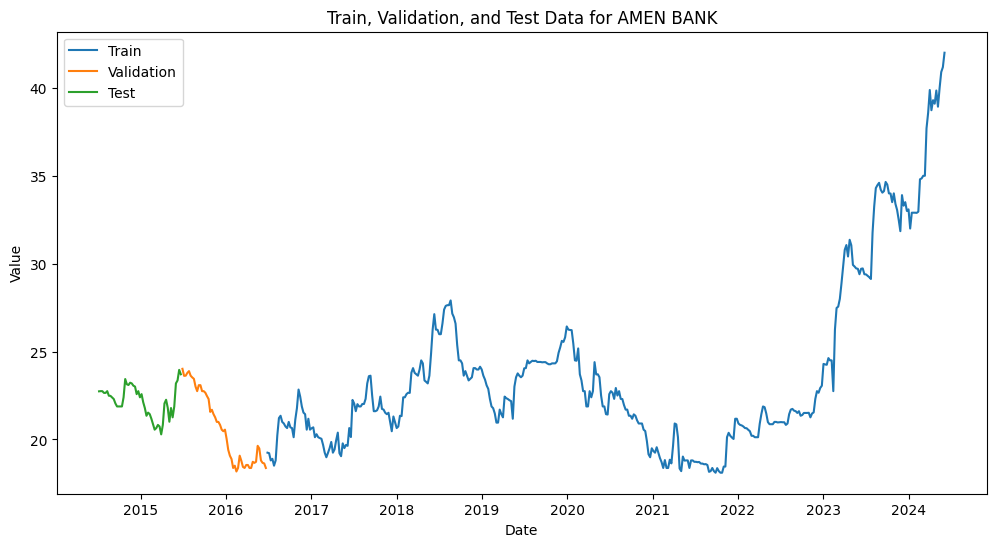

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0890 - mean_absolute_error: 0.2241 - val_loss: 0.0066 - val_mean_absolute_error: 0.0679
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0464 - mean_absolute_error: 0.1379 - val_loss: 0.0092 - val_mean_absolute_error: 0.0805
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0216 - mean_absolute_error: 0.1092 - val_loss: 0.0151 - val_mean_absolute_error: 0.1161
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0104 - mean_absolute_error: 0.0857 - val_loss: 0.0022 - val_mean_absolute_error: 0.0404
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0021 - mean_absolute_error: 0.0339 - val_loss: 3.0778e-04 - val_mean_absolute_error: 0.0144
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0016 - mean_absolute_error: 0.0290 - val_loss: 4.1814e-04 - val_mean_absolute_error: 0.0175
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0013 - mean_absolute_error: 0.0

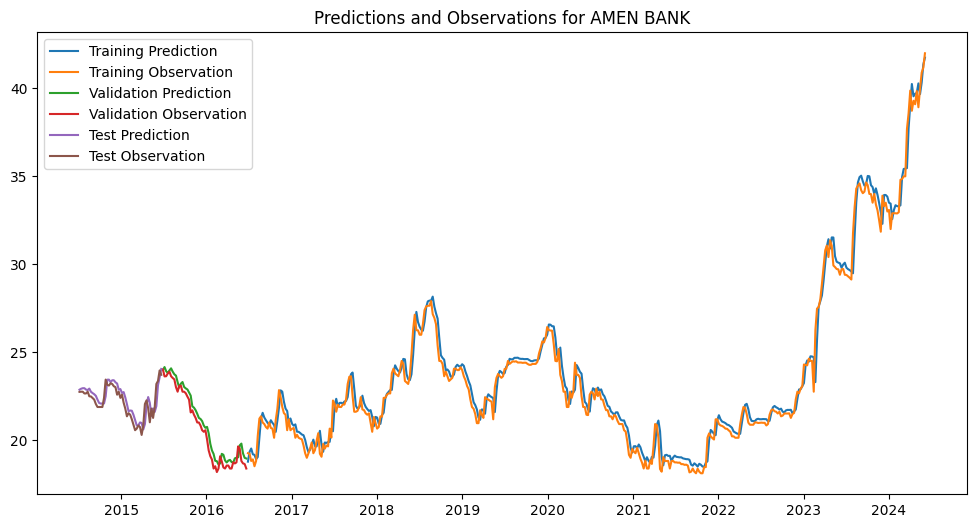

Starting recursive predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━

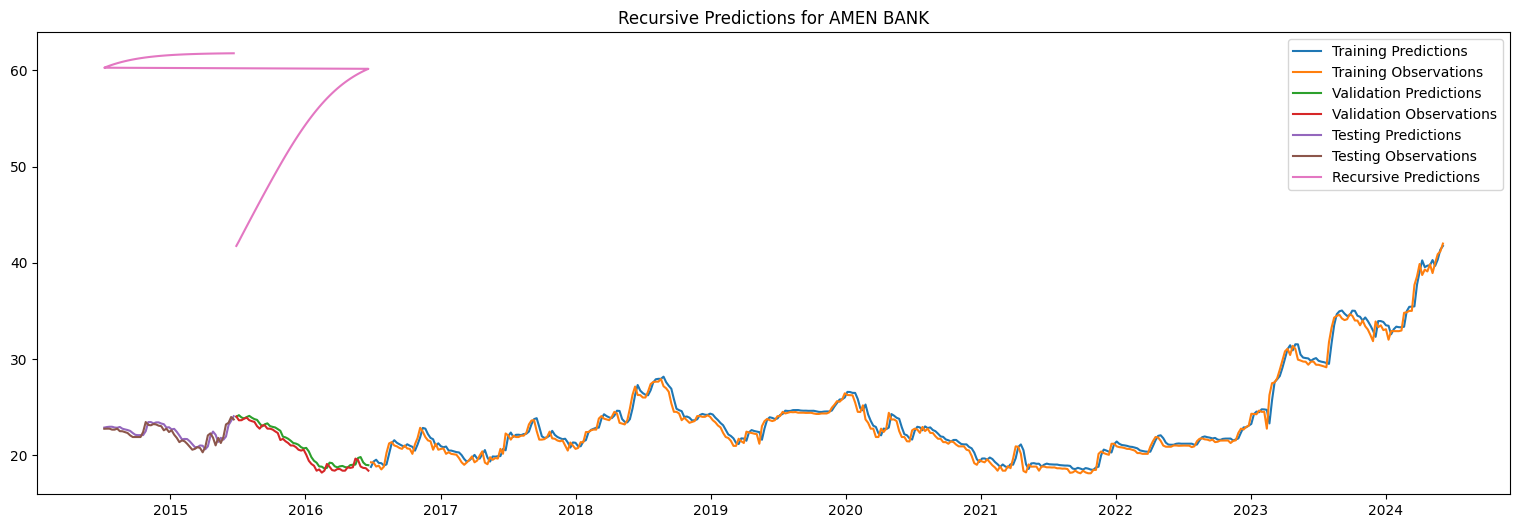

Training and plotting for ARTES
Starting process for ARTES...


C:\Users\Kahla\AppData\Local\Temp\ipykernel_11060\285995610.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


Splitting data into train, validation, and test sets...


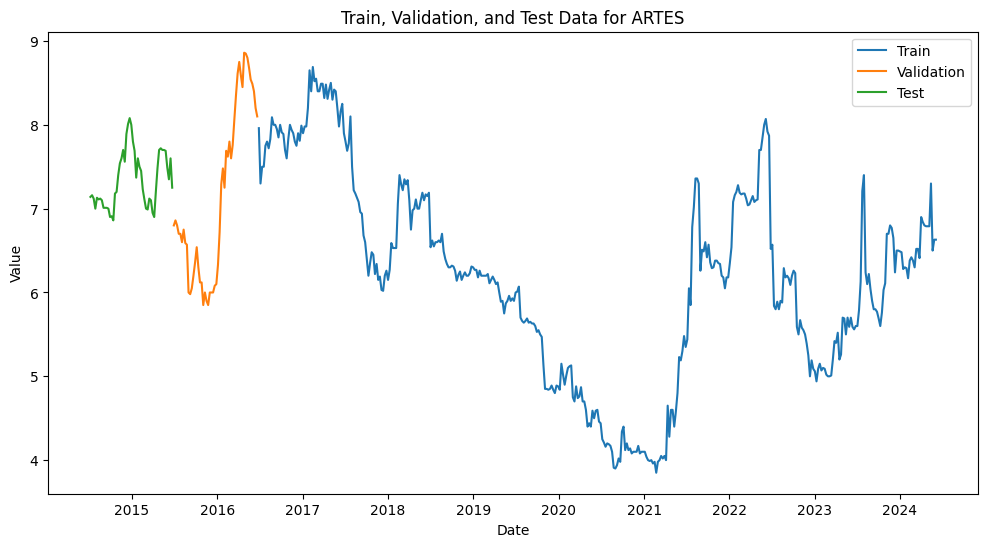

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.2205 - mean_absolute_error: 0.4156 - val_loss: 0.2309 - val_mean_absolute_error: 0.4489
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0852 - mean_absolute_error: 0.2416 - val_loss: 0.0249 - val_mean_absolute_error: 0.1206
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0148 - mean_absolute_error: 0.0989 - val_loss: 0.0120 - val_mean_absolute_error: 0.0857
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0104 - mean_absolute_error: 0.0821 - val_loss: 0.0056 - val_mean_absolute_error: 0.0609
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068 - mean_absolute_error: 0.0644 - val_loss: 0.0062 - val_mean_absolute_error: 0.0590
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - mean_absolute_error: 0.0423 - val_loss: 0.0046 - val_mean_absolute_error: 0.0501
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - mean_absolute_error: 0.0398 - val_lo

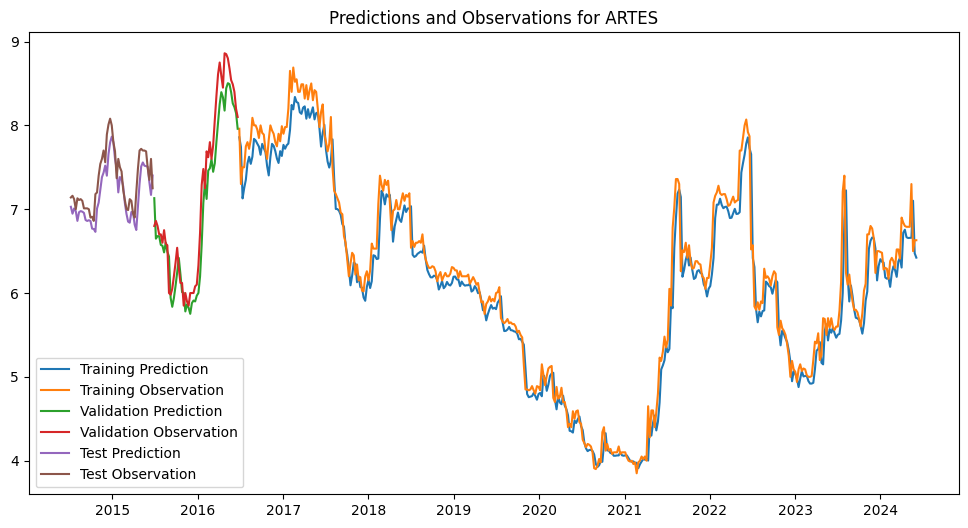

Starting recursive predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━

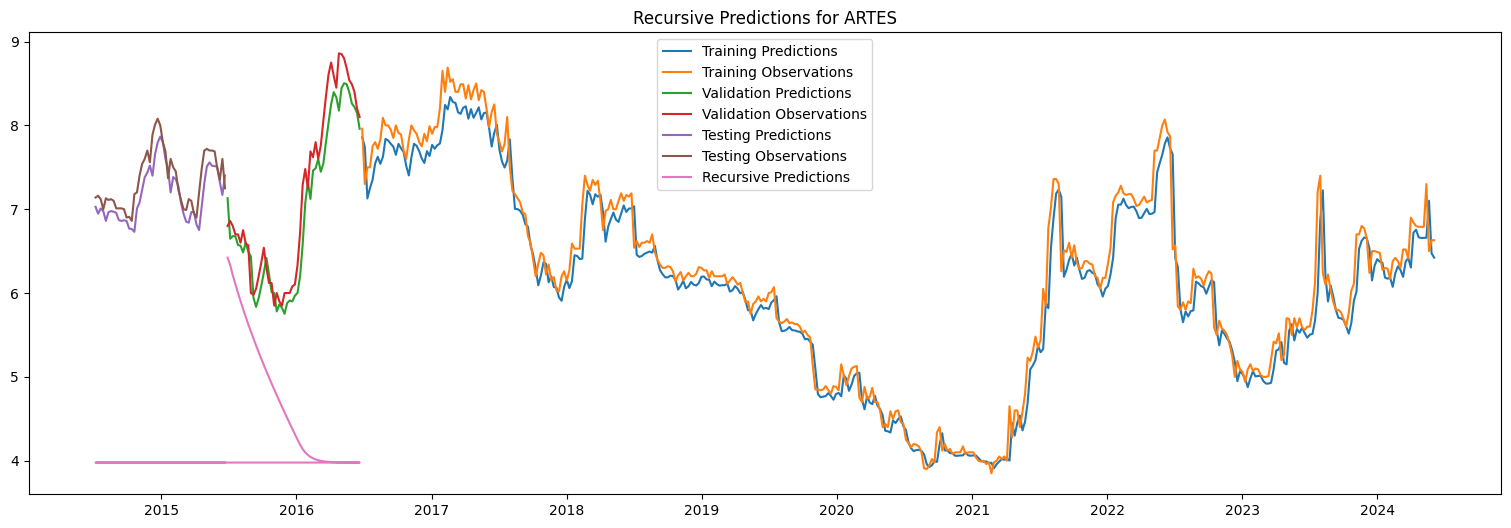

Training and plotting for ASSAD
Starting process for ASSAD...


C:\Users\Kahla\AppData\Local\Temp\ipykernel_11060\285995610.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


Splitting data into train, validation, and test sets...


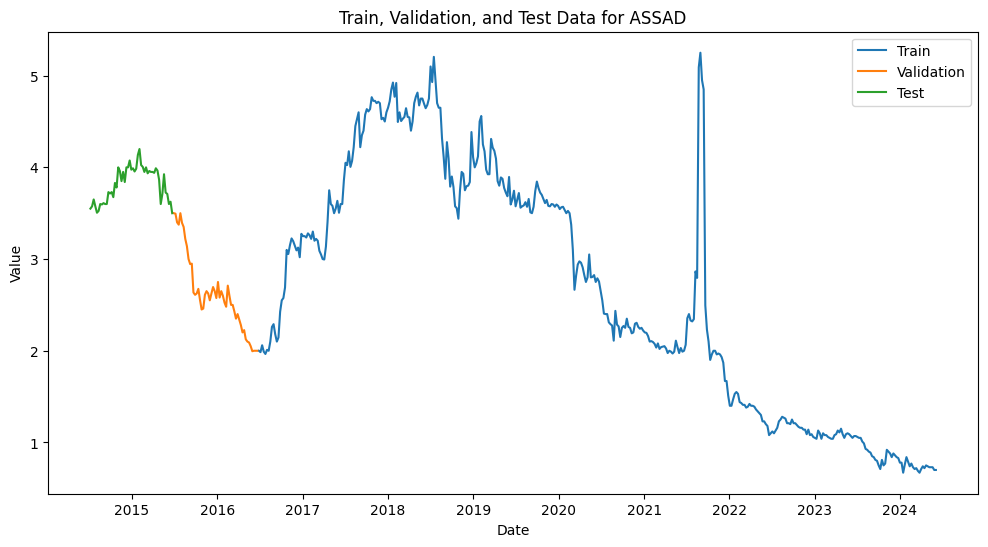

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.2411 - mean_absolute_error: 0.3976 - val_loss: 0.0987 - val_mean_absolute_error: 0.3037
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1145 - mean_absolute_error: 0.2648 - val_loss: 0.0118 - val_mean_absolute_error: 0.0923
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0301 - mean_absolute_error: 0.1465 - val_loss: 0.0087 - val_mean_absolute_error: 0.0886
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0143 - mean_absolute_error: 0.0974 - val_loss: 0.0016 - val_mean_absolute_error: 0.0341
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0046 - mean_absolute_error: 0.0506 - val_loss: 5.3727e-04 - val_mean_absolute_error: 0.0169
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0041 - mean_absolute_error: 0.0297 - val_loss: 4.8084e-04 - val_mean_absolute_error: 0.0158
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024 - mean_absolute_error: 0.0266 -

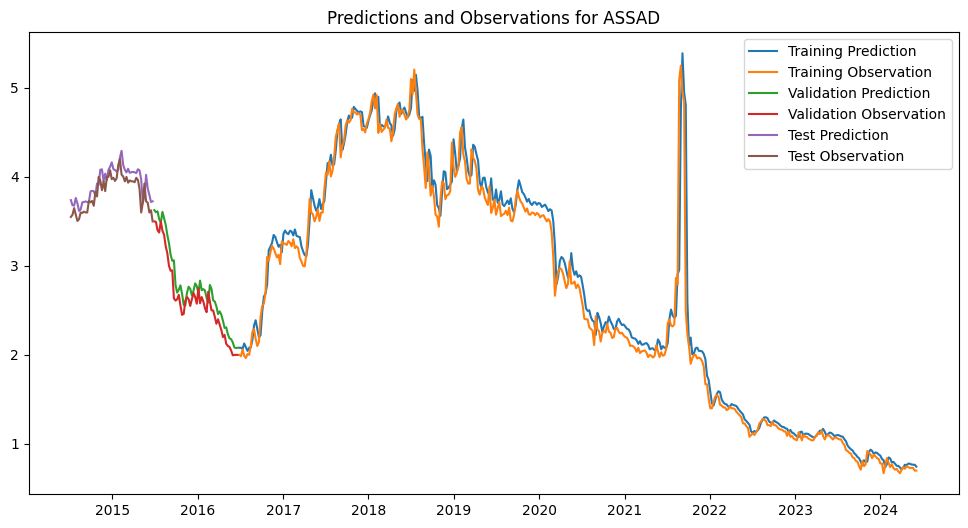

Starting recursive predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━

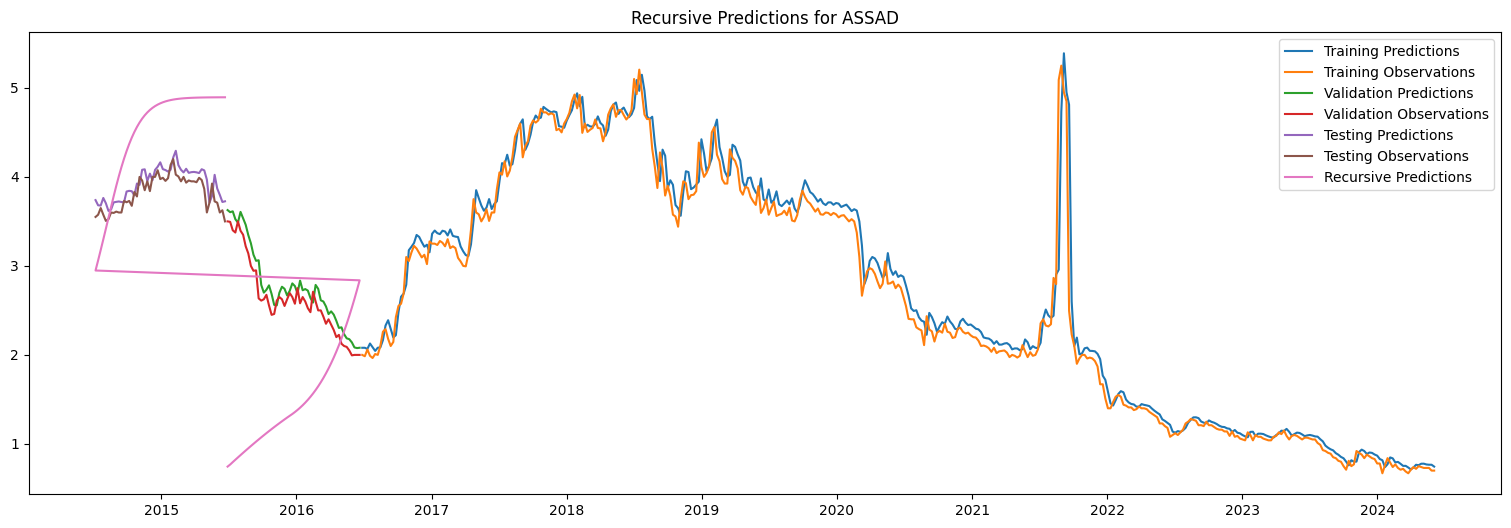

Training and plotting for BIAT
Starting process for BIAT...


C:\Users\Kahla\AppData\Local\Temp\ipykernel_11060\285995610.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


Splitting data into train, validation, and test sets...


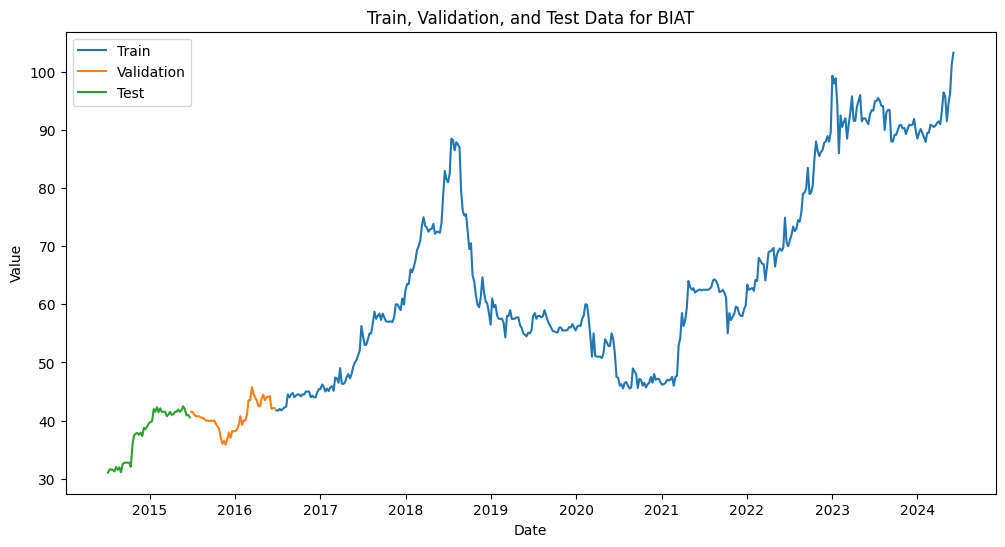

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.2731 - mean_absolute_error: 0.4686 - val_loss: 0.0055 - val_mean_absolute_error: 0.0666
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1666 - mean_absolute_error: 0.3456 - val_loss: 0.0094 - val_mean_absolute_error: 0.0933
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0291 - mean_absolute_error: 0.1317 - val_loss: 0.0666 - val_mean_absolute_error: 0.2574
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0209 - mean_absolute_error: 0.1251 - val_loss: 0.0279 - val_mean_absolute_error: 0.1658
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0110 - mean_absolute_error: 0.0861 - val_loss: 0.0236 - val_mean_absolute_error: 0.1524
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0075 - mean_absolute_error: 0.0759 - val_loss: 0.0190 - val_mean_absolute_error: 0.1366
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0058 - mean_absolute_error: 0.0652 - val_lo

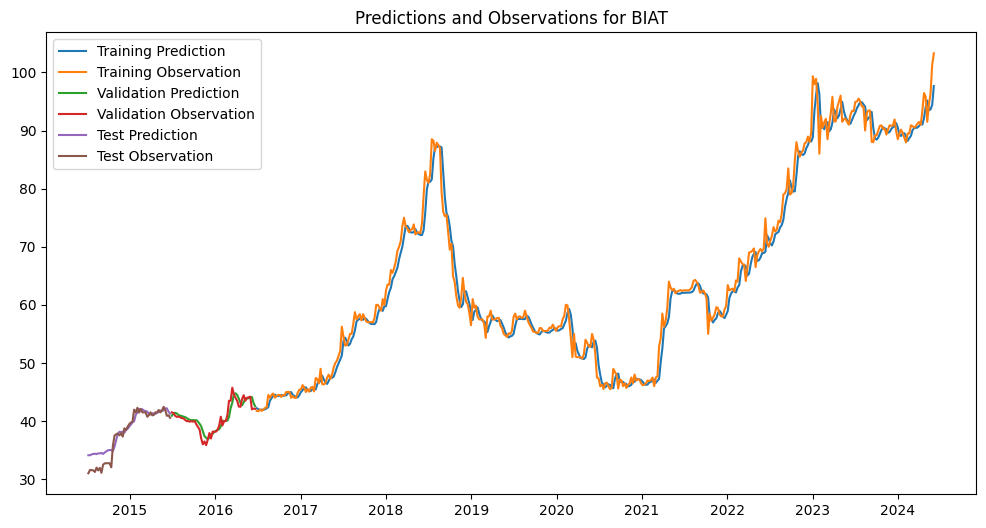

Starting recursive predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━

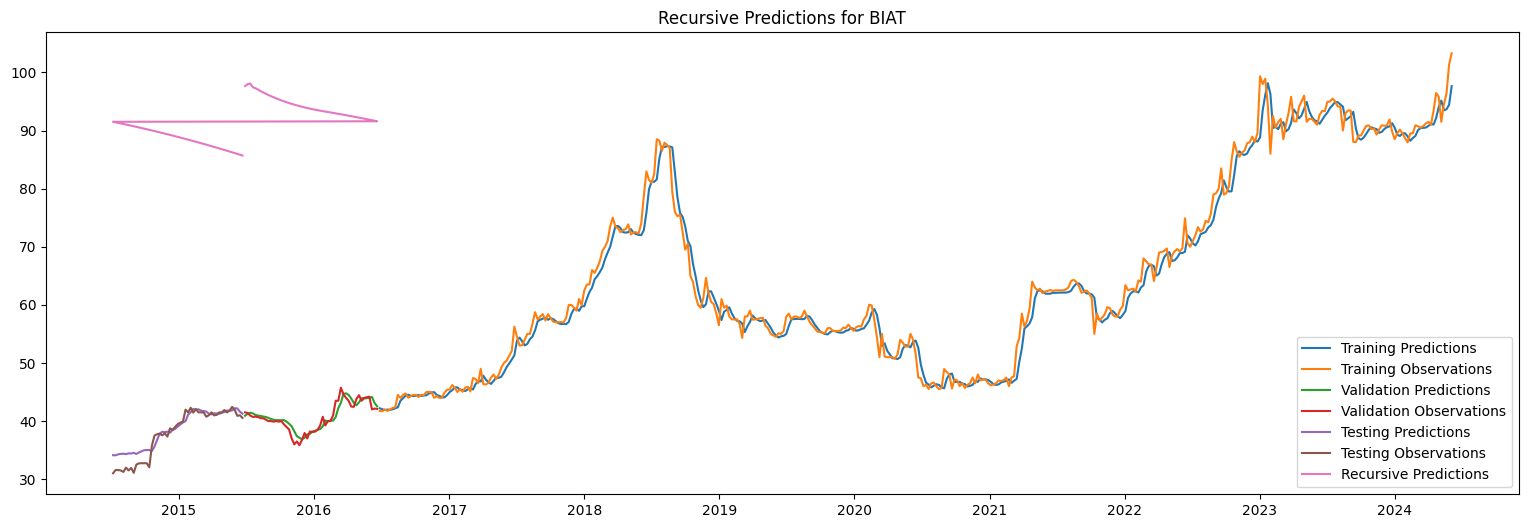

Training and plotting for BANQUE DE TUNISIE
Starting process for BANQUE DE TUNISIE...


C:\Users\Kahla\AppData\Local\Temp\ipykernel_11060\285995610.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


Splitting data into train, validation, and test sets...


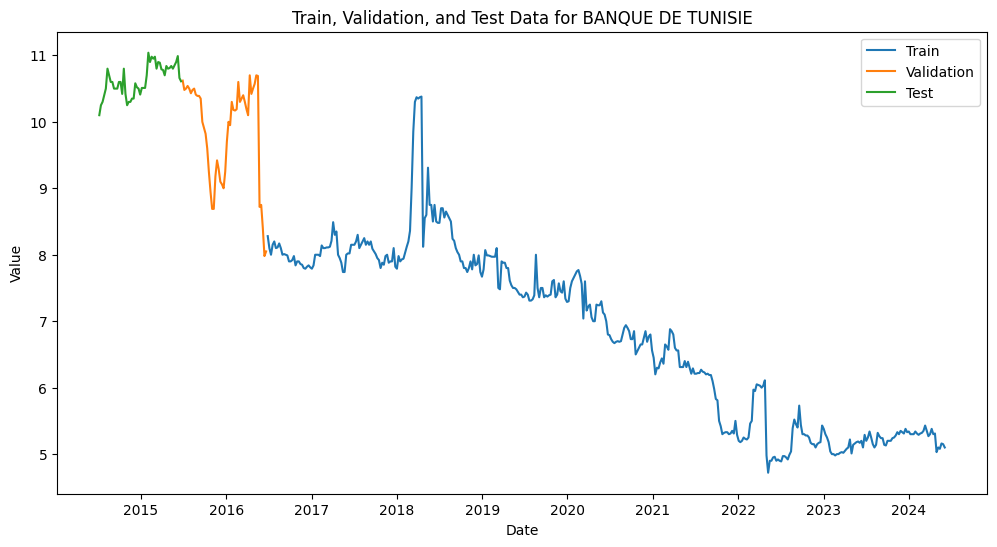

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - loss: 0.1014 - mean_absolute_error: 0.2597 - val_loss: 0.1913 - val_mean_absolute_error: 0.4272
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0228 - mean_absolute_error: 0.1261 - val_loss: 0.0129 - val_mean_absolute_error: 0.1042
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0138 - mean_absolute_error: 0.0927 - val_loss: 0.0447 - val_mean_absolute_error: 0.1982
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0073 - mean_absolute_error: 0.0750 - val_loss: 0.0128 - val_mean_absolute_error: 0.1032
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0036 - mean_absolute_error: 0.0458 - val_loss: 0.0068 - val_mean_absolute_error: 0.0690
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0015 - mean_absolute_error: 0.0256 - val_loss: 0.0060 - val_mean_absolute_error: 0.0526
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0010 - mean_absolute_error: 0.0200 -

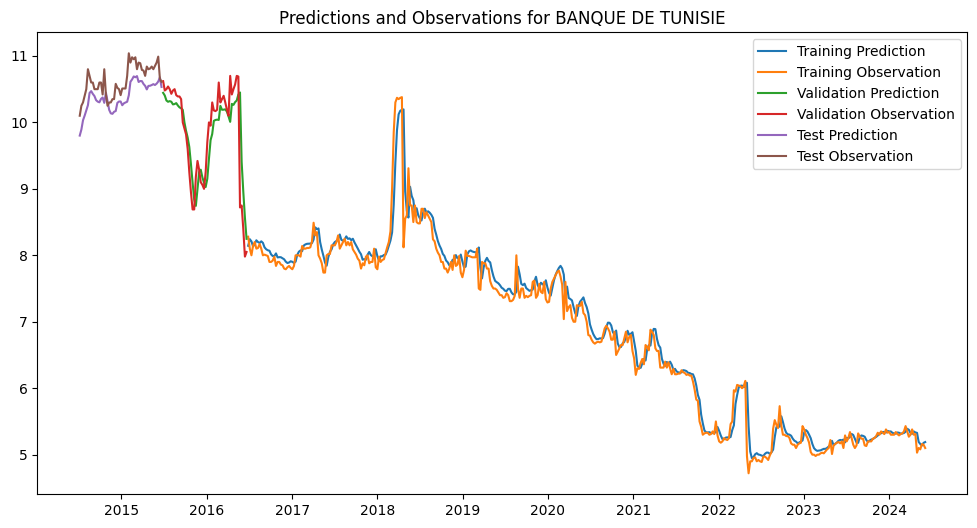

Starting recursive predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━

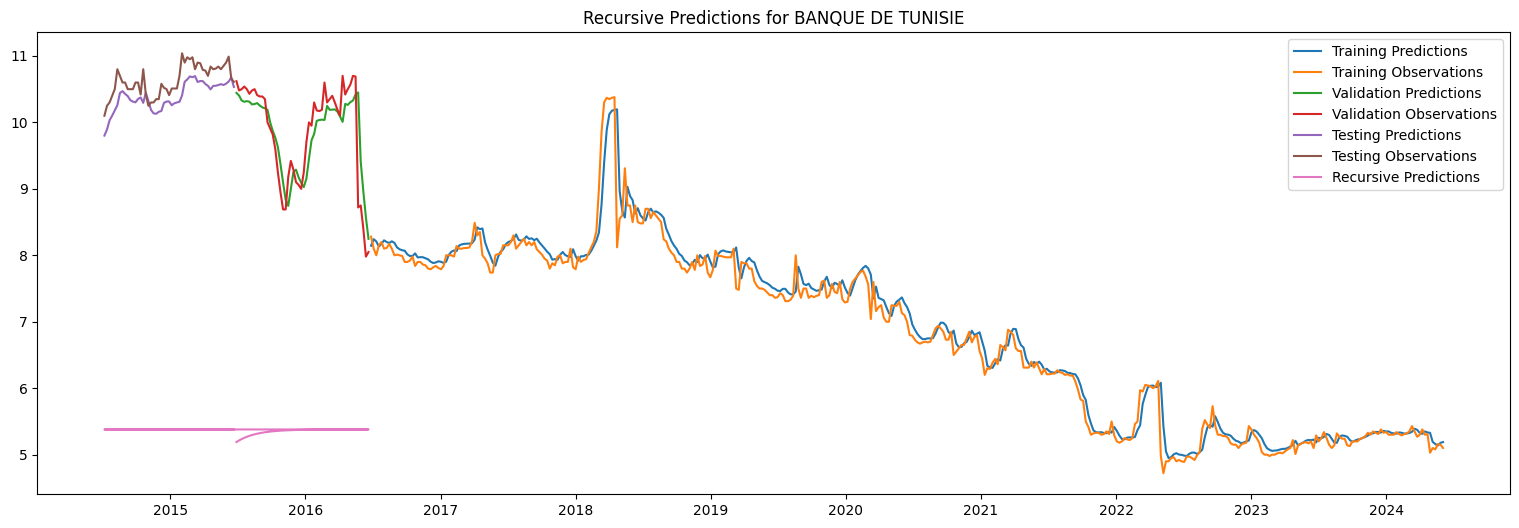

Training and plotting for EURO-CYCLES
Starting process for EURO-CYCLES...


C:\Users\Kahla\AppData\Local\Temp\ipykernel_11060\285995610.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


Splitting data into train, validation, and test sets...


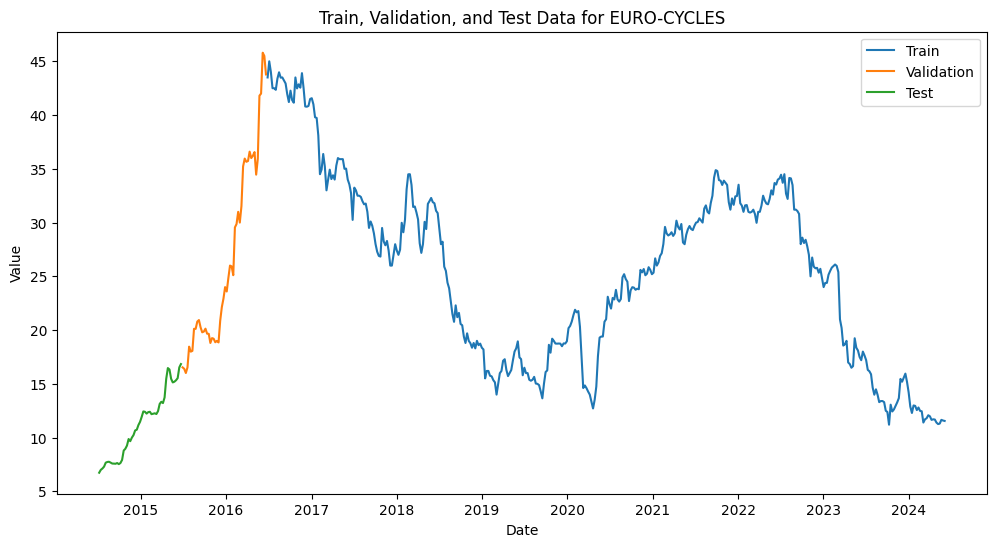

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - loss: 0.1932 - mean_absolute_error: 0.3943 - val_loss: 0.0775 - val_mean_absolute_error: 0.2291
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0365 - mean_absolute_error: 0.1503 - val_loss: 0.0165 - val_mean_absolute_error: 0.1136
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0168 - mean_absolute_error: 0.1106 - val_loss: 0.0142 - val_mean_absolute_error: 0.0914
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0103 - mean_absolute_error: 0.0847 - val_loss: 0.0087 - val_mean_absolute_error: 0.0761
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0060 - mean_absolute_error: 0.0634 - val_loss: 0.0063 - val_mean_absolute_error: 0.0626
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0038 - mean_absolute_error: 0.0519 - val_loss: 0.0052 - val_mean_absolute_error: 0.0536
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0025 - mean_absolute_error: 0.0406 - v

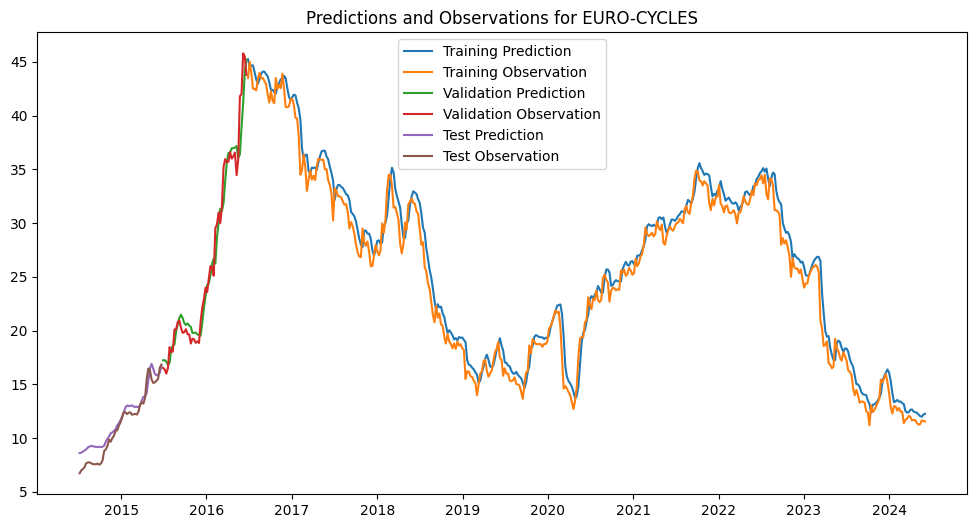

Starting recursive predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━

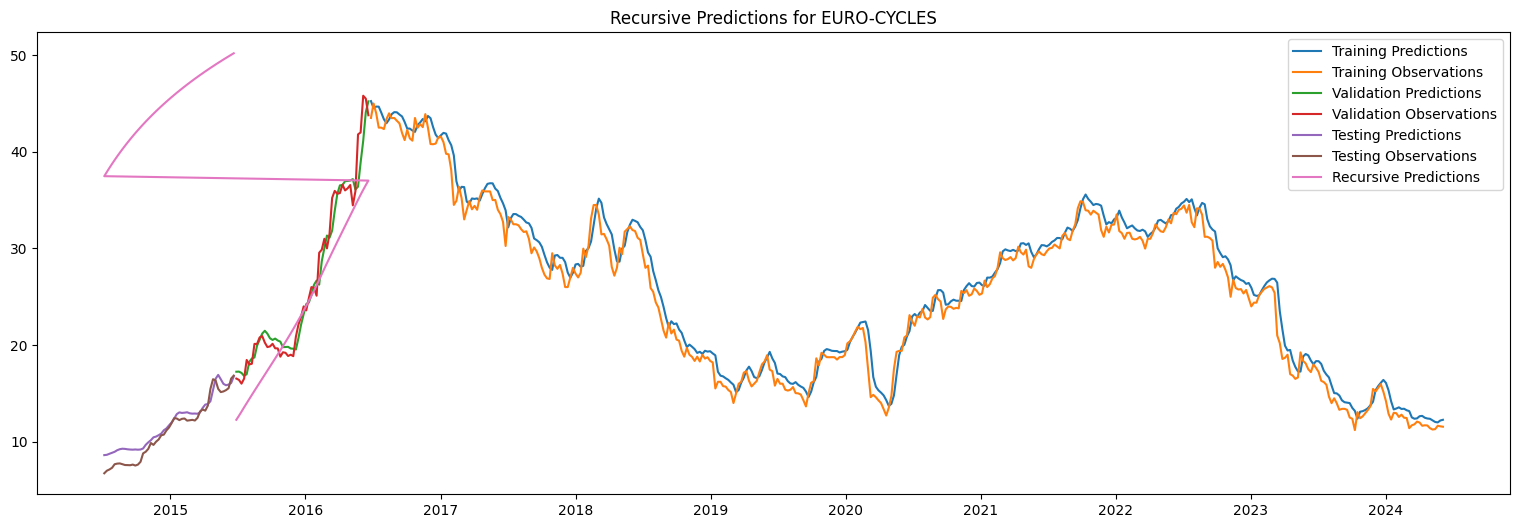

Training and plotting for SOTUMAG
Starting process for SOTUMAG...


C:\Users\Kahla\AppData\Local\Temp\ipykernel_11060\285995610.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


Splitting data into train, validation, and test sets...


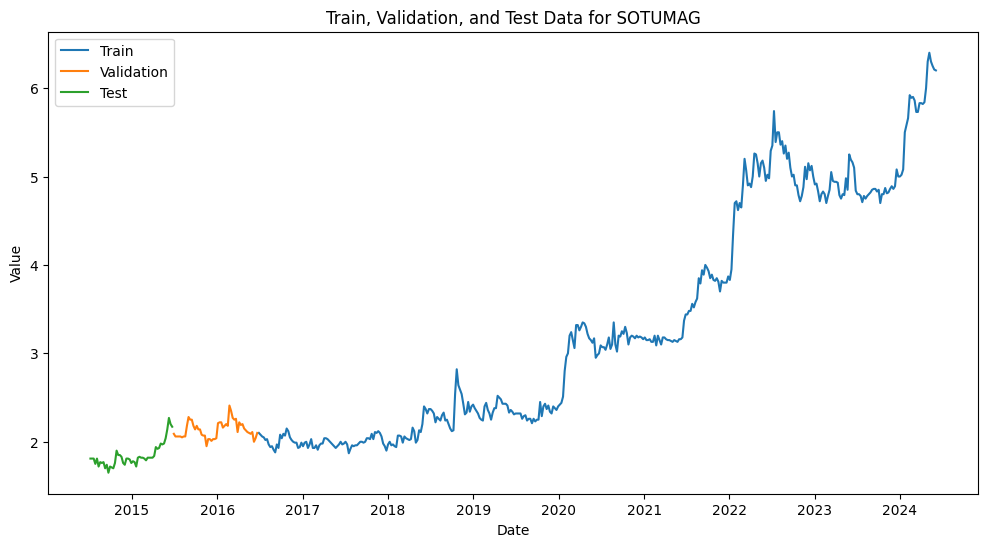

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - loss: 0.1596 - mean_absolute_error: 0.3091 - val_loss: 4.1880e-04 - val_mean_absolute_error: 0.0154
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0884 - mean_absolute_error: 0.2082 - val_loss: 0.0194 - val_mean_absolute_error: 0.1385
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0248 - mean_absolute_error: 0.1382 - val_loss: 0.0376 - val_mean_absolute_error: 0.1933
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0167 - mean_absolute_error: 0.1142 - val_loss: 0.0108 - val_mean_absolute_error: 0.1026
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0075 - mean_absolute_error: 0.0756 - val_loss: 0.0054 - val_mean_absolute_error: 0.0719
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0020 - mean_absolute_error: 0.0361 - val_loss: 3.2143e-04 - val_mean_absolute_error: 0.0155
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011 - mean_absolute_error: 0.

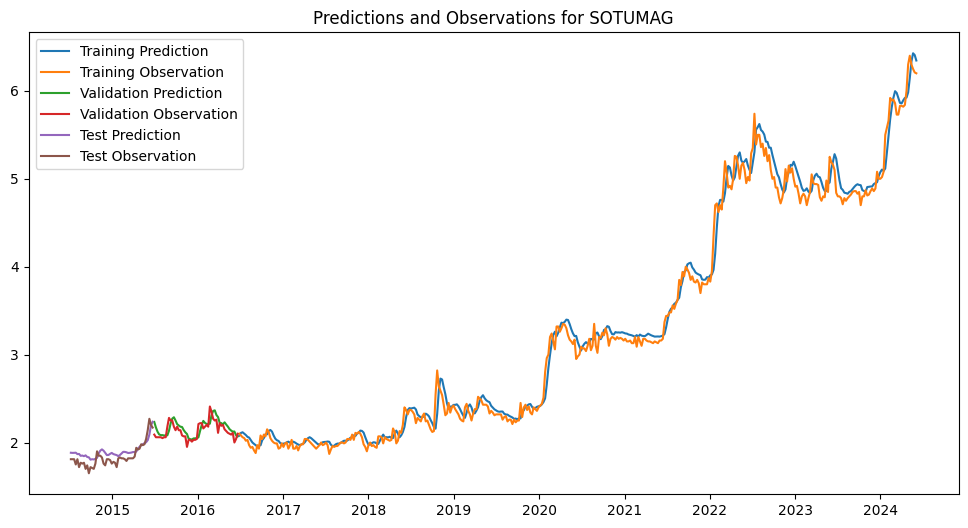

Starting recursive predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━

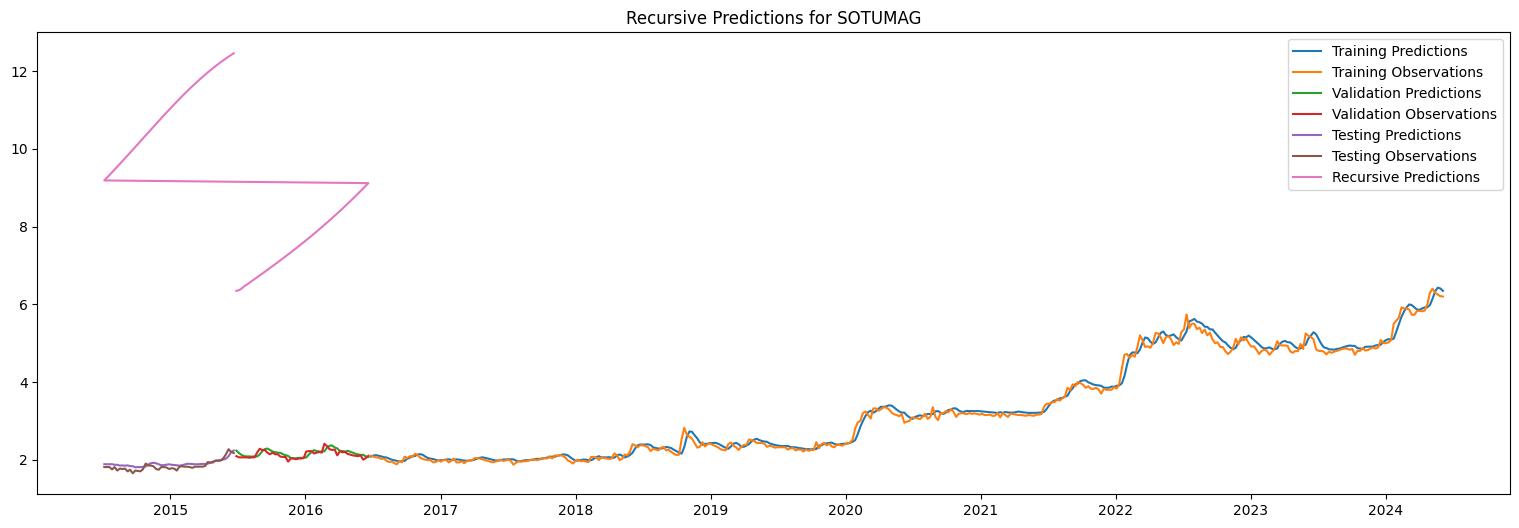

Training and plotting for ONE TECH
Starting process for ONE TECH...


C:\Users\Kahla\AppData\Local\Temp\ipykernel_11060\285995610.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


No more data available for the next week.
Splitting data into train, validation, and test sets...


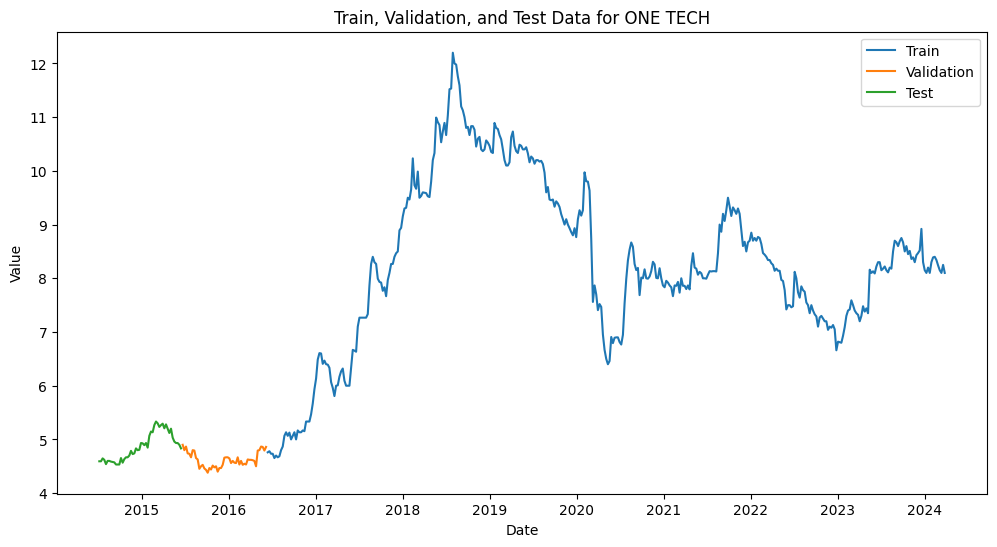

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - loss: 0.2716 - mean_absolute_error: 0.4838 - val_loss: 8.6732e-04 - val_mean_absolute_error: 0.0255
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1681 - mean_absolute_error: 0.3705 - val_loss: 0.0158 - val_mean_absolute_error: 0.1247
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0459 - mean_absolute_error: 0.1771 - val_loss: 0.0733 - val_mean_absolute_error: 0.2706
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0134 - mean_absolute_error: 0.0954 - val_loss: 0.0448 - val_mean_absolute_error: 0.2112
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0081 - mean_absolute_error: 0.0691 - val_loss: 0.0423 - val_mean_absolute_error: 0.2053
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0064 - mean_absolute_error: 0.0629 - val_loss: 0.0279 - val_mean_absolute_error: 0.1665
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0045 - mean_absolute_error: 0.0520

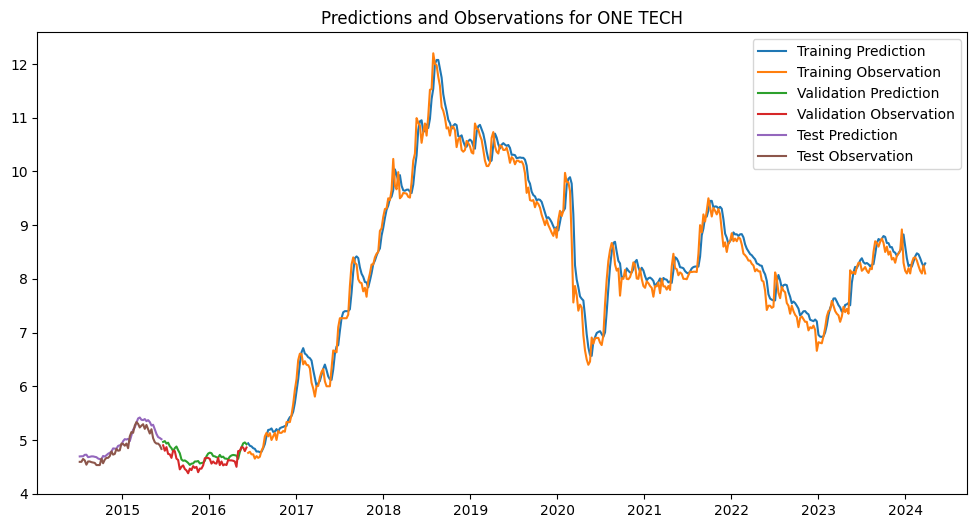

Starting recursive predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━

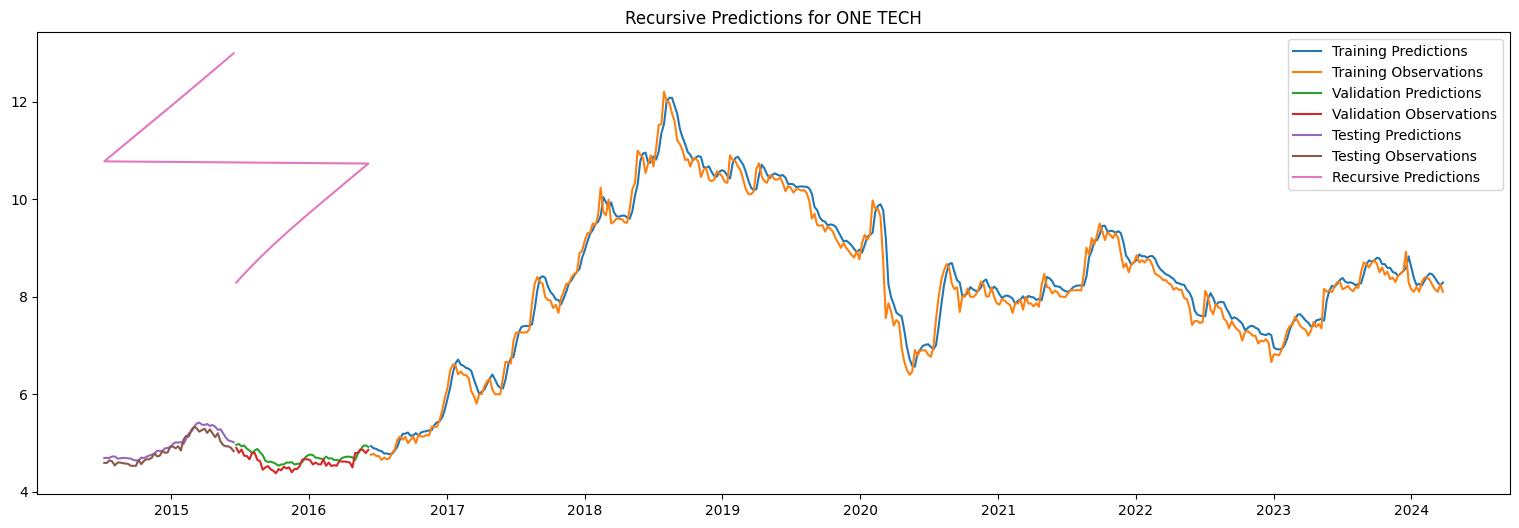

Training and plotting for SAH
Starting process for SAH...


C:\Users\Kahla\AppData\Local\Temp\ipykernel_11060\285995610.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


Splitting data into train, validation, and test sets...


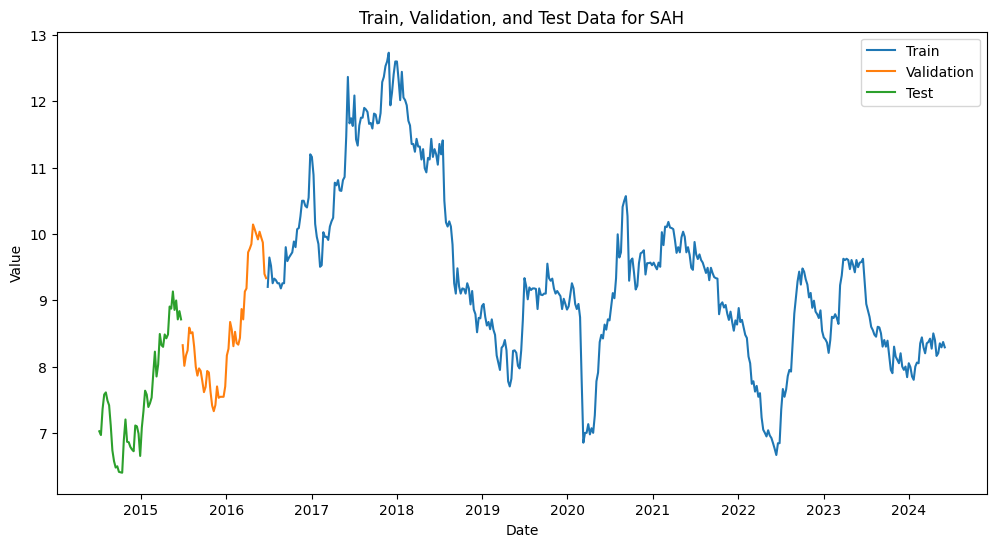

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 0.2567 - mean_absolute_error: 0.4660 - val_loss: 0.1043 - val_mean_absolute_error: 0.2951
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2105 - mean_absolute_error: 0.4105 - val_loss: 0.0711 - val_mean_absolute_error: 0.2333
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1581 - mean_absolute_error: 0.3465 - val_loss: 0.0299 - val_mean_absolute_error: 0.1304
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0703 - mean_absolute_error: 0.2057 - val_loss: 0.0128 - val_mean_absolute_error: 0.1000
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0150 - mean_absolute_error: 0.0990 - val_loss: 0.0120 - val_mean_absolute_error: 0.0948
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0115 - mean_absolute_error: 0.0839 - val_loss: 0.0099 - val_mean_absolute_error: 0.0843
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0069 - mean_absolute_error: 0.0667 - v

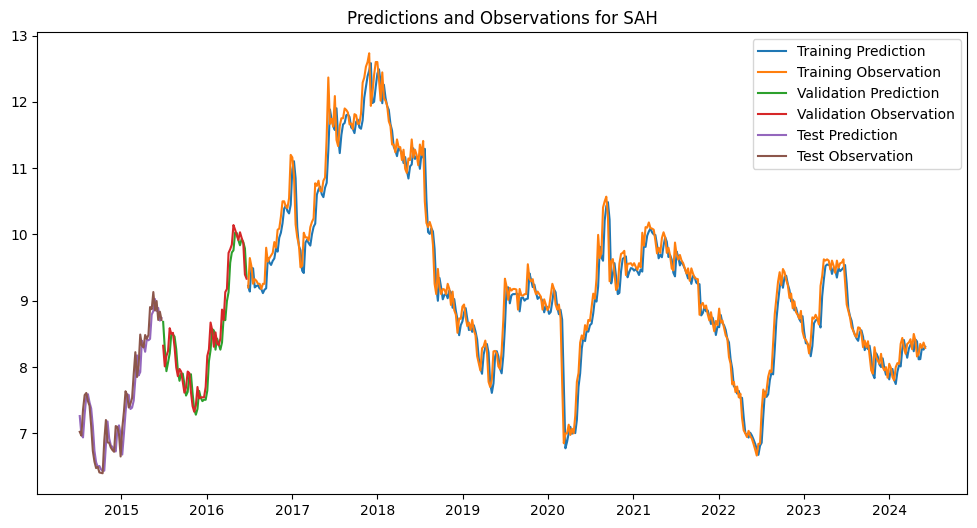

Starting recursive predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━

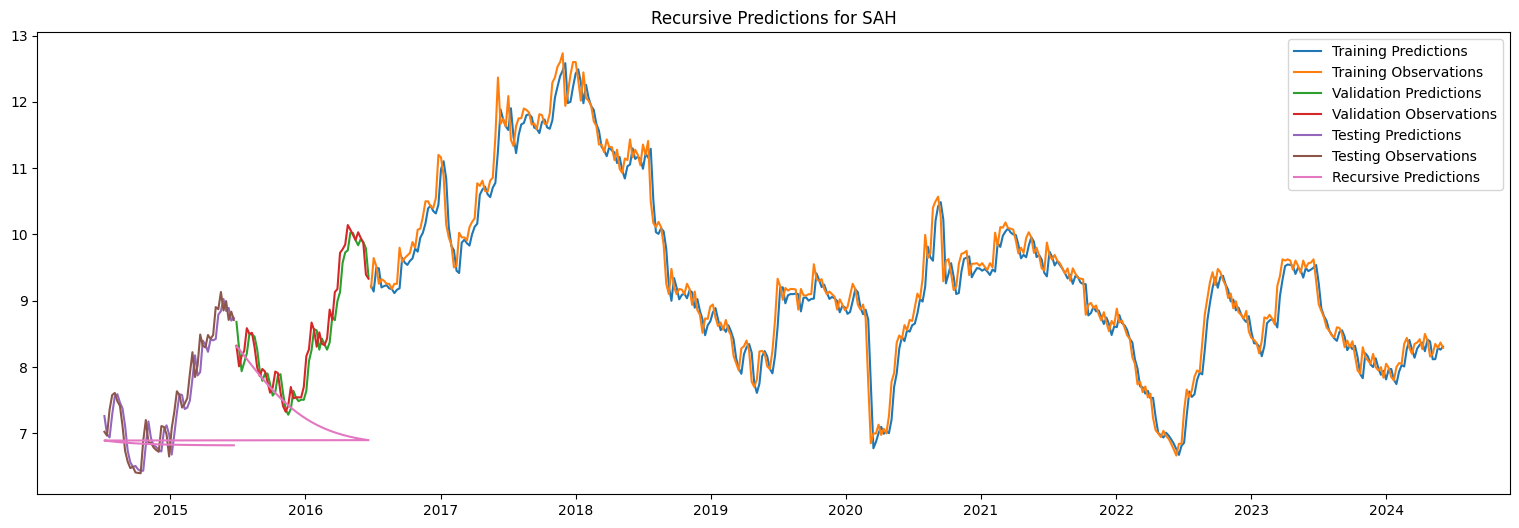

Training and plotting for SFBT
Starting process for SFBT...


C:\Users\Kahla\AppData\Local\Temp\ipykernel_11060\285995610.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


Splitting data into train, validation, and test sets...


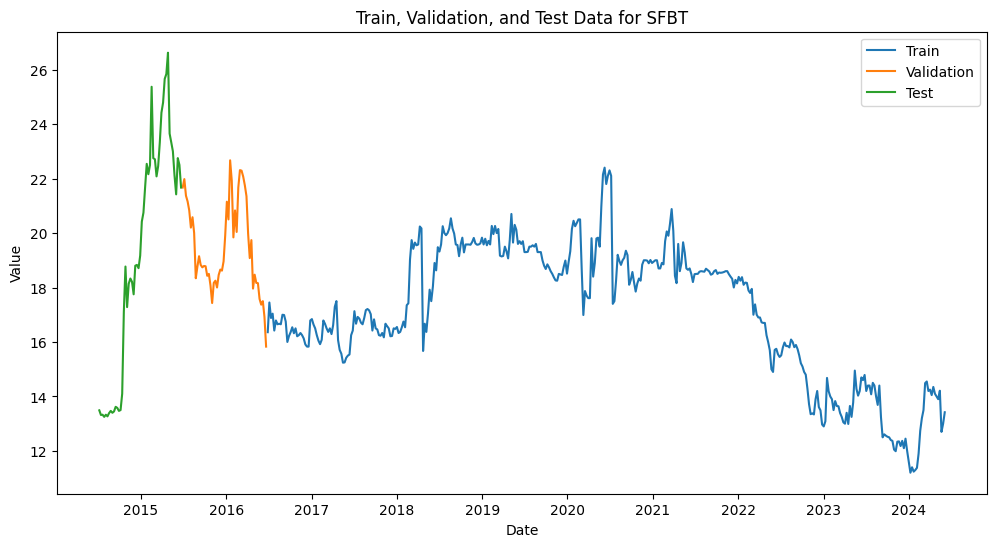

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - loss: 0.1294 - mean_absolute_error: 0.3274 - val_loss: 0.0882 - val_mean_absolute_error: 0.2847
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0279 - mean_absolute_error: 0.1399 - val_loss: 0.0042 - val_mean_absolute_error: 0.0494
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0076 - mean_absolute_error: 0.0676 - val_loss: 0.0095 - val_mean_absolute_error: 0.0778
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0058 - mean_absolute_error: 0.0629 - val_loss: 0.0042 - val_mean_absolute_error: 0.0482
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0047 - mean_absolute_error: 0.0547 - val_loss: 0.0045 - val_mean_absolute_error: 0.0507
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0038 - mean_absolute_error: 0.0470 - val_loss: 0.0034 - val_mean_absolute_error: 0.0410
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0024 - mean_absolute_error: 0.0358 - v

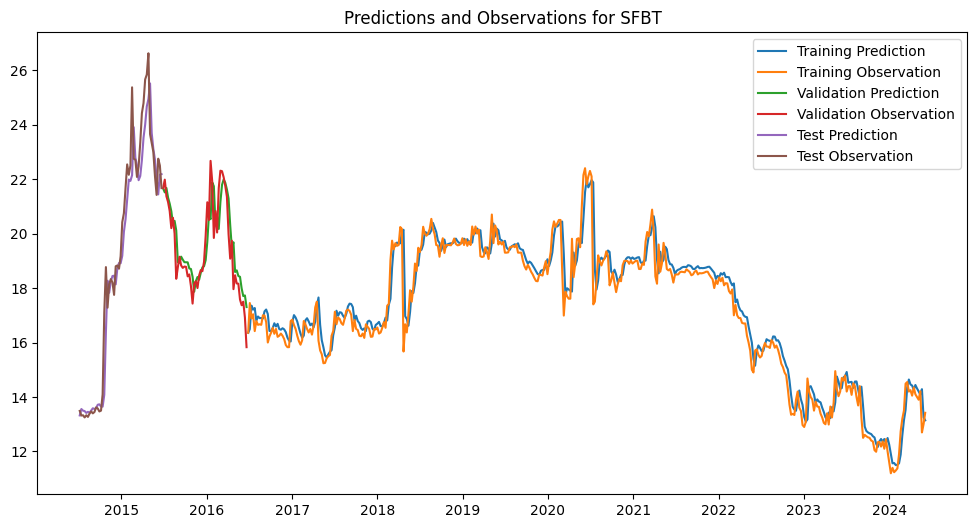

Starting recursive predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━

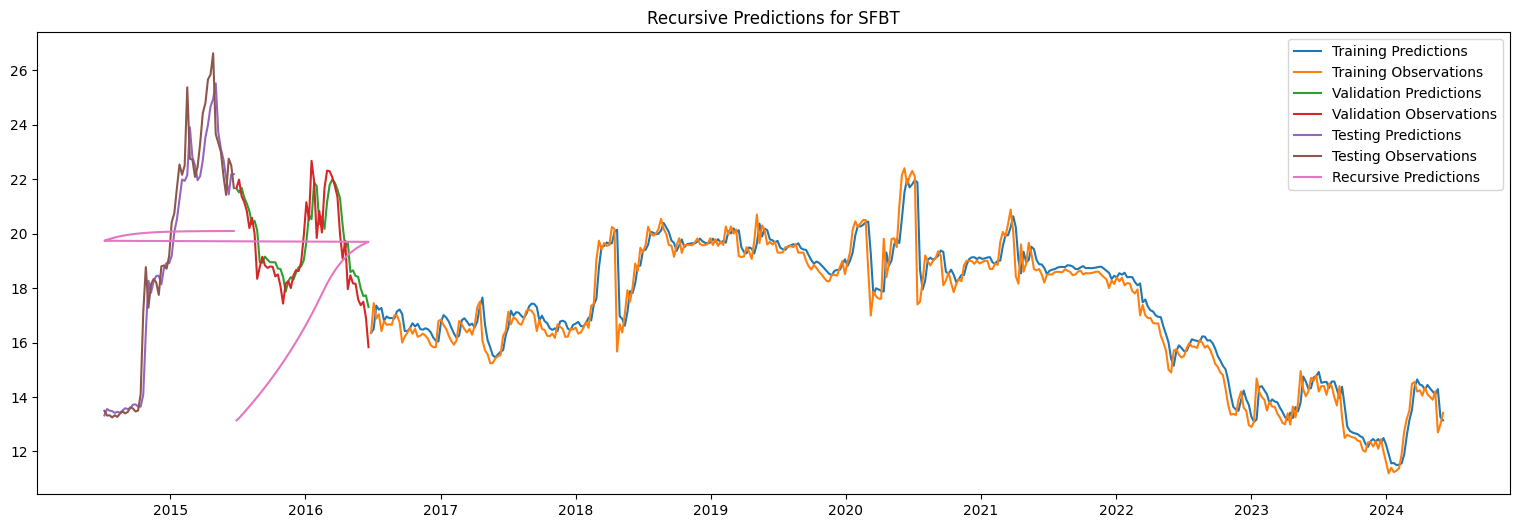

Training and plotting for SOMOCER
Starting process for SOMOCER...


C:\Users\Kahla\AppData\Local\Temp\ipykernel_11060\285995610.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


Splitting data into train, validation, and test sets...


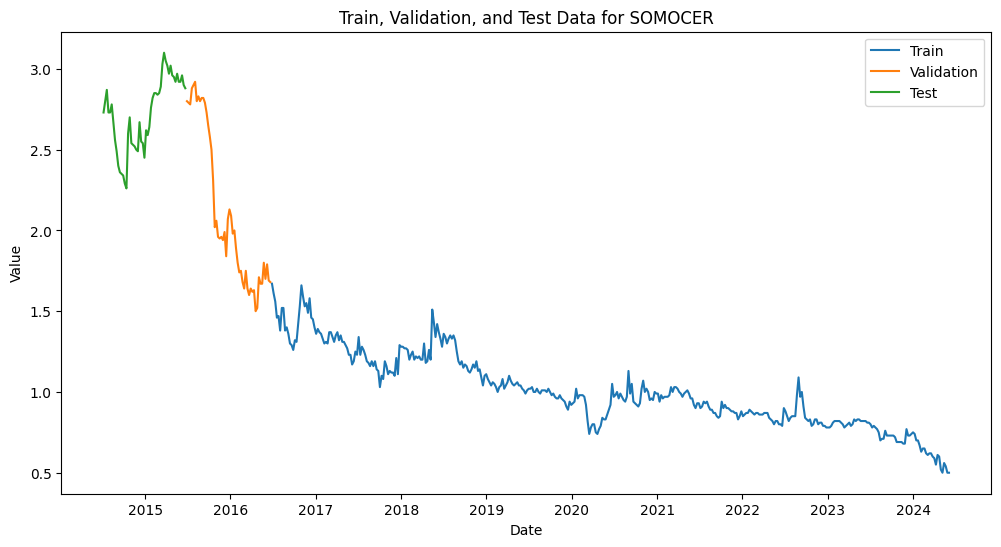

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 0.0379 - mean_absolute_error: 0.1687 - val_loss: 0.1884 - val_mean_absolute_error: 0.4076
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0069 - mean_absolute_error: 0.0620 - val_loss: 0.0638 - val_mean_absolute_error: 0.2234
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0037 - mean_absolute_error: 0.0506 - val_loss: 0.0702 - val_mean_absolute_error: 0.2445
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0022 - mean_absolute_error: 0.0370 - val_loss: 0.0266 - val_mean_absolute_error: 0.1406
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0012 - mean_absolute_error: 0.0277 - val_loss: 0.0150 - val_mean_absolute_error: 0.1017
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.2255e-04 - mean_absolute_error: 0.0185 - val_loss: 0.0072 - val_mean_absolute_error: 0.0663
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.6306e-04 - mean_absolute_error: 0.

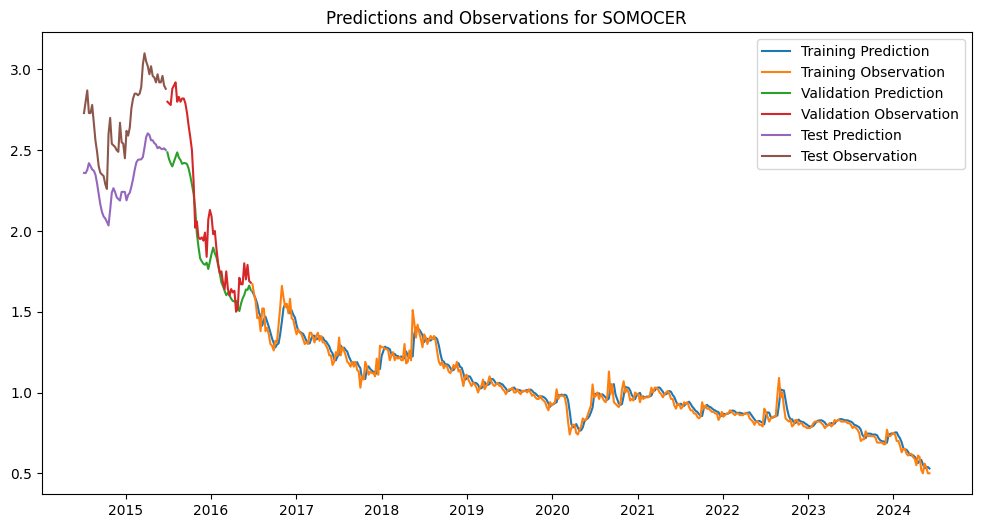

Starting recursive predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━

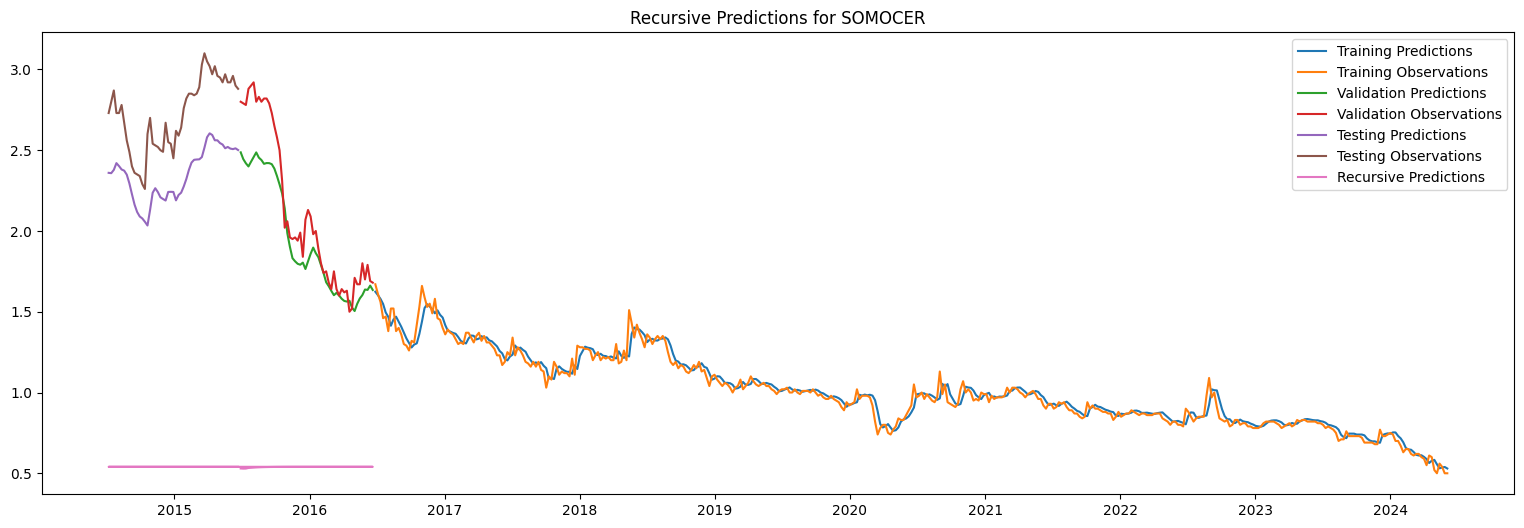

Training and plotting for SOTETEL
Starting process for SOTETEL...


C:\Users\Kahla\AppData\Local\Temp\ipykernel_11060\285995610.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


Splitting data into train, validation, and test sets...


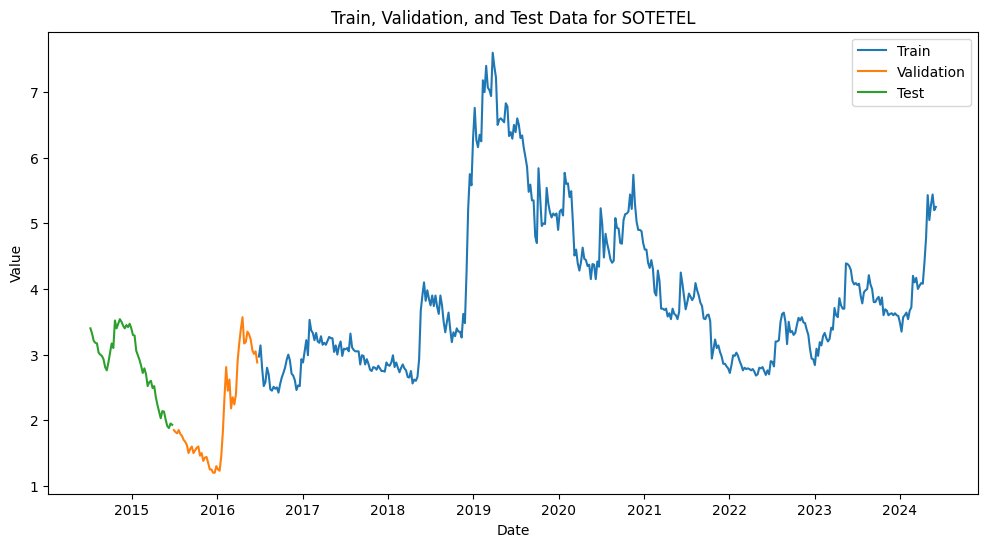

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 0.1844 - mean_absolute_error: 0.3940 - val_loss: 0.0143 - val_mean_absolute_error: 0.0877
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1072 - mean_absolute_error: 0.2822 - val_loss: 0.0123 - val_mean_absolute_error: 0.0995
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0248 - mean_absolute_error: 0.1082 - val_loss: 0.0483 - val_mean_absolute_error: 0.2092
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0139 - mean_absolute_error: 0.1061 - val_loss: 0.0329 - val_mean_absolute_error: 0.1674
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0090 - mean_absolute_error: 0.0757 - val_loss: 0.0248 - val_mean_absolute_error: 0.1423
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0065 - mean_absolute_error: 0.0654 - val_loss: 0.0240 - val_mean_absolute_error: 0.1419
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0063 - mean_absolute_error: 0.0685 - 

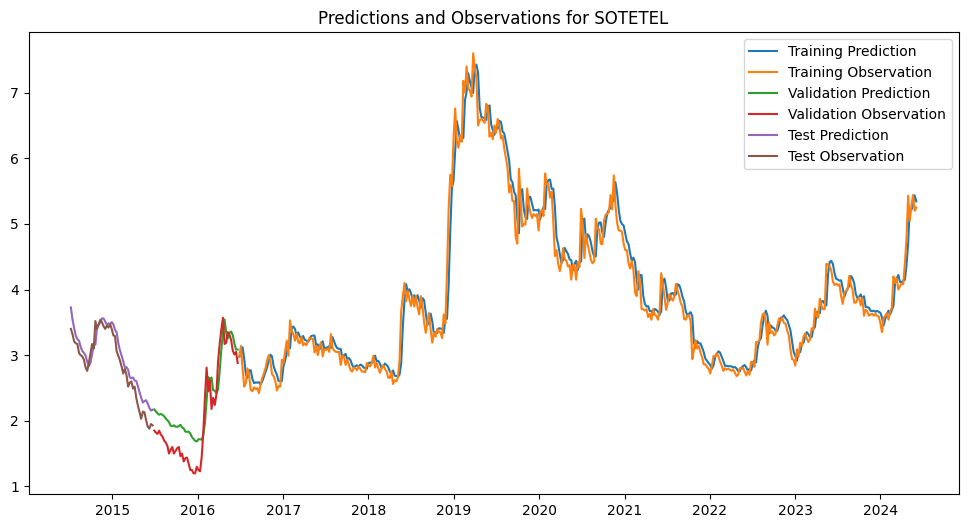

Starting recursive predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━

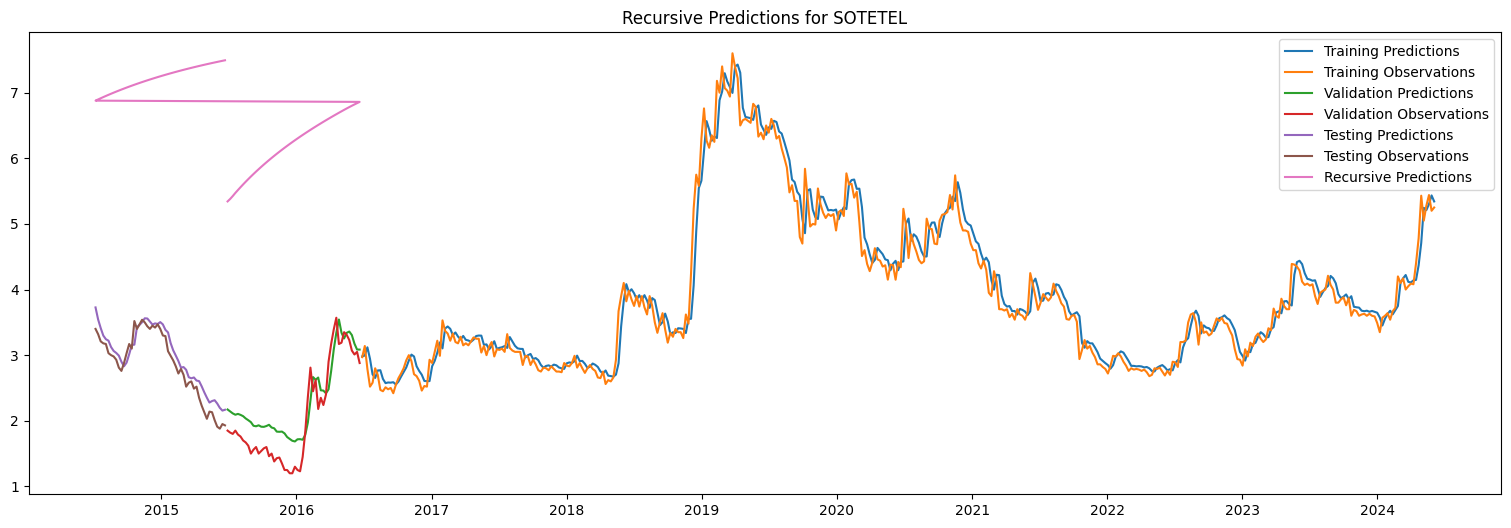

Training and plotting for SOTUVER
Starting process for SOTUVER...


C:\Users\Kahla\AppData\Local\Temp\ipykernel_11060\285995610.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


Splitting data into train, validation, and test sets...


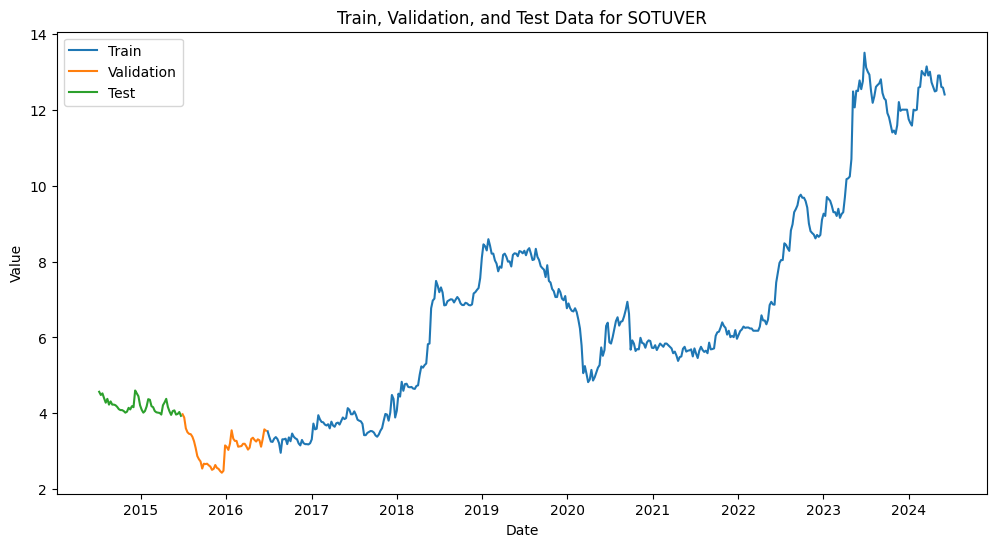

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - loss: 0.2458 - mean_absolute_error: 0.4206 - val_loss: 0.0022 - val_mean_absolute_error: 0.0385
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0994 - mean_absolute_error: 0.2463 - val_loss: 0.0382 - val_mean_absolute_error: 0.1939
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0262 - mean_absolute_error: 0.1340 - val_loss: 0.0707 - val_mean_absolute_error: 0.2651
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0216 - mean_absolute_error: 0.1281 - val_loss: 0.0298 - val_mean_absolute_error: 0.1714
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0108 - mean_absolute_error: 0.0833 - val_loss: 0.0227 - val_mean_absolute_error: 0.1494
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0065 - mean_absolute_error: 0.0684 - val_loss: 0.0108 - val_mean_absolute_error: 0.1023
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0024 - mean_absolute_error: 0.0385 - v

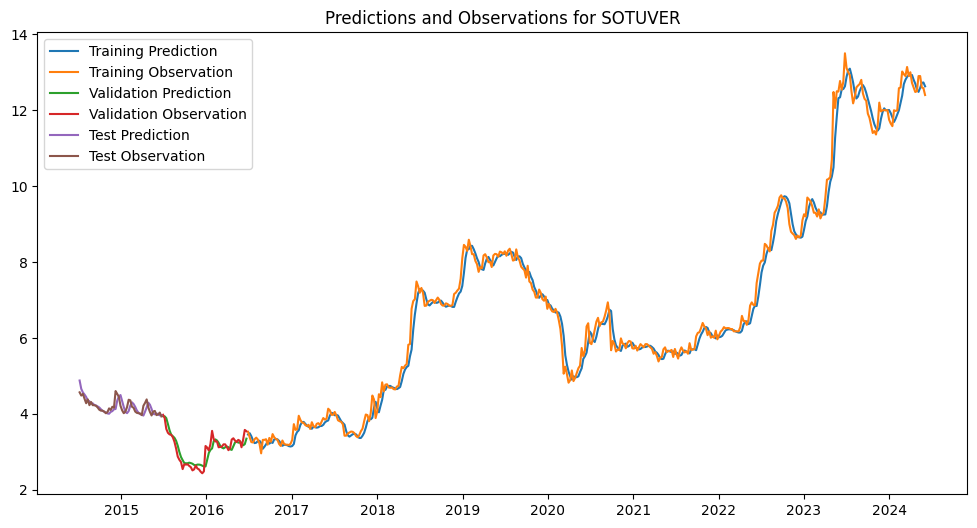

Starting recursive predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━

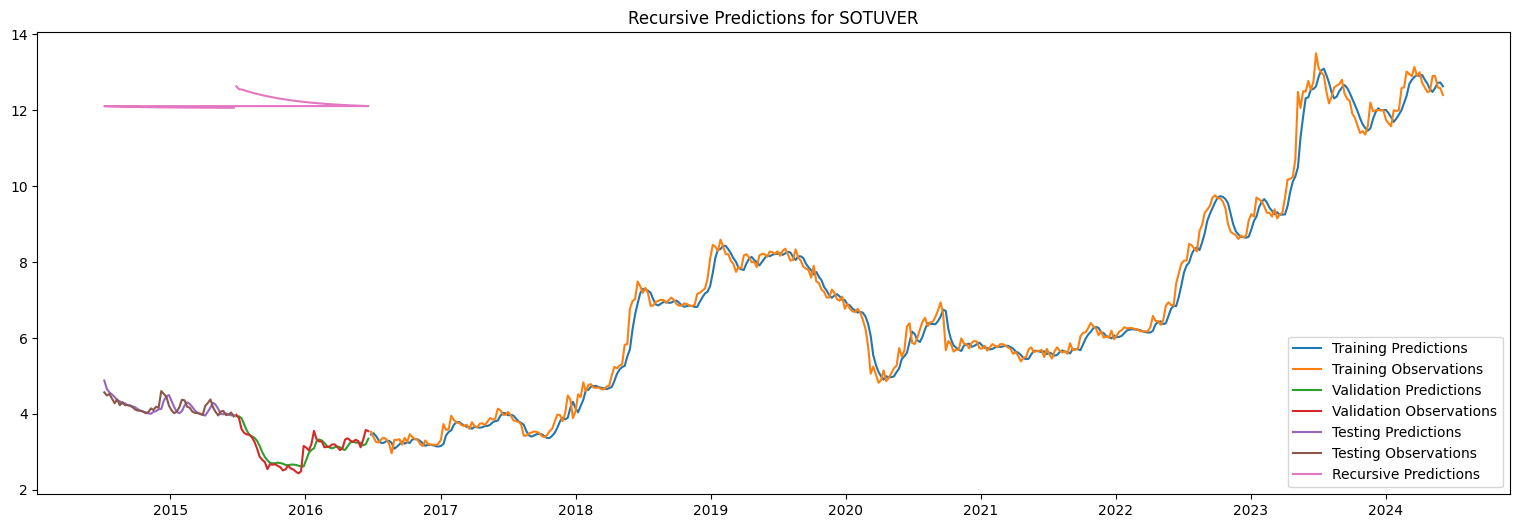

Training and plotting for TUNISAIR
Starting process for TUNISAIR...


C:\Users\Kahla\AppData\Local\Temp\ipykernel_11060\285995610.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


Splitting data into train, validation, and test sets...


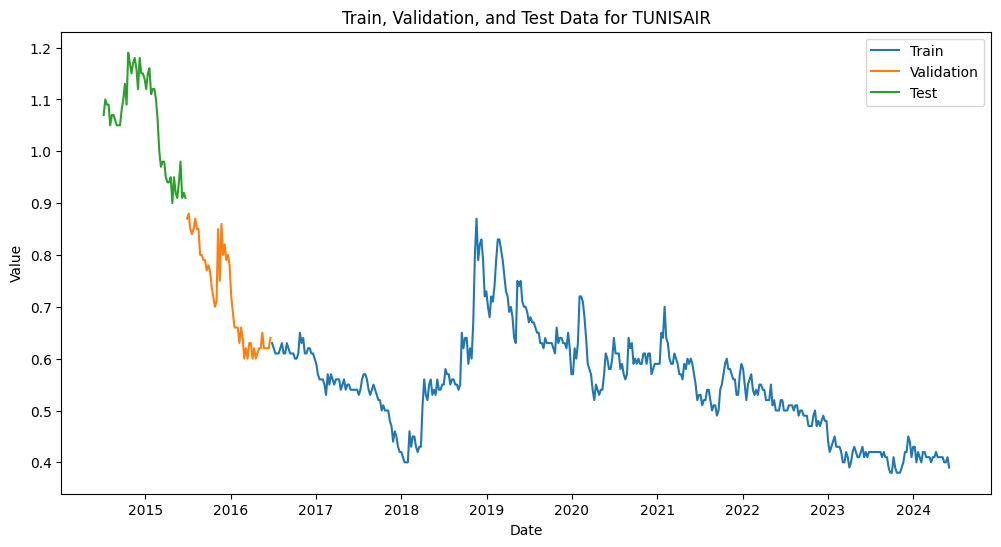

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0499 - mean_absolute_error: 0.1858 - val_loss: 0.0636 - val_mean_absolute_error: 0.2333
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0111 - mean_absolute_error: 0.0809 - val_loss: 0.0104 - val_mean_absolute_error: 0.0781
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051 - mean_absolute_error: 0.0544 - val_loss: 0.0084 - val_mean_absolute_error: 0.0738
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - mean_absolute_error: 0.0408 - val_loss: 0.0027 - val_mean_absolute_error: 0.0367
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0015 - mean_absolute_error: 0.0262 - val_loss: 0.0019 - val_mean_absolute_error: 0.0290
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011 - mean_absolute_error: 0.0216 - val_loss: 0.0019 - val_mean_absolute_error: 0.0293
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0010 - mean_absolute_error: 0.0211 - val_lo

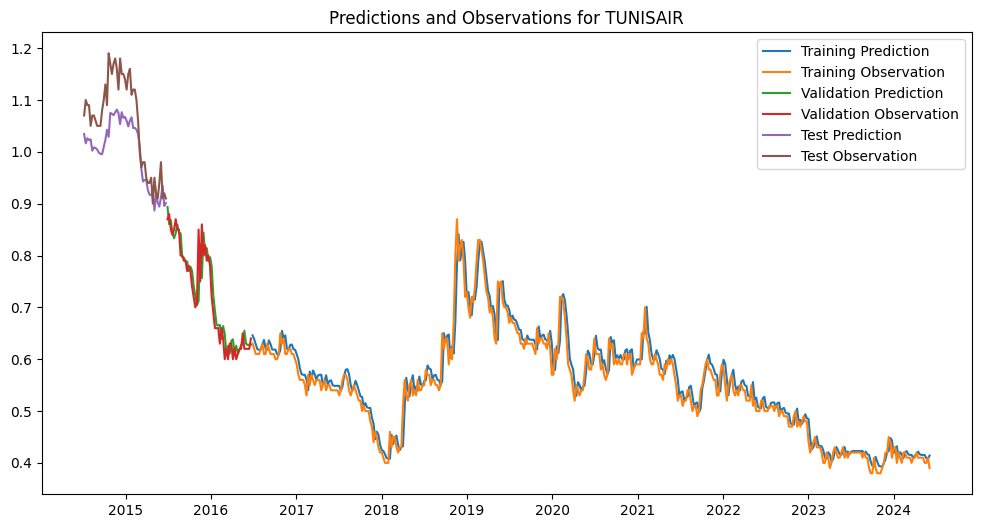

Starting recursive predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━

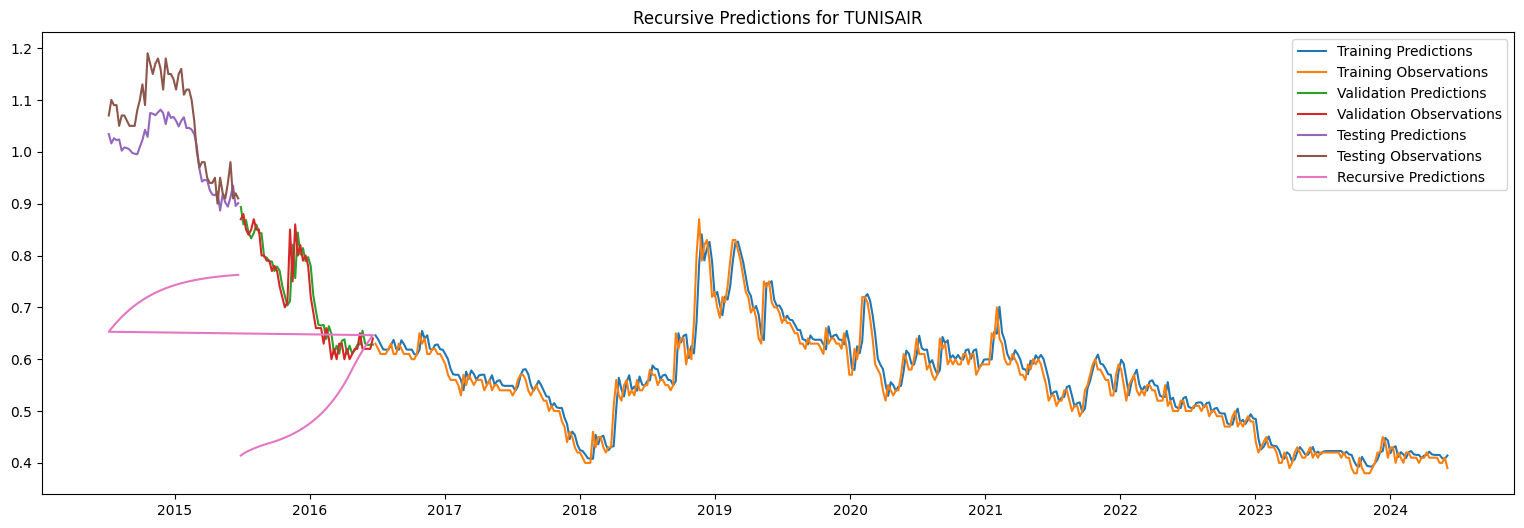

Training and plotting for BANQUE ATTIJARI DE TUNIS
Starting process for BANQUE ATTIJARI DE TUNIS...


C:\Users\Kahla\AppData\Local\Temp\ipykernel_11060\285995610.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


Splitting data into train, validation, and test sets...


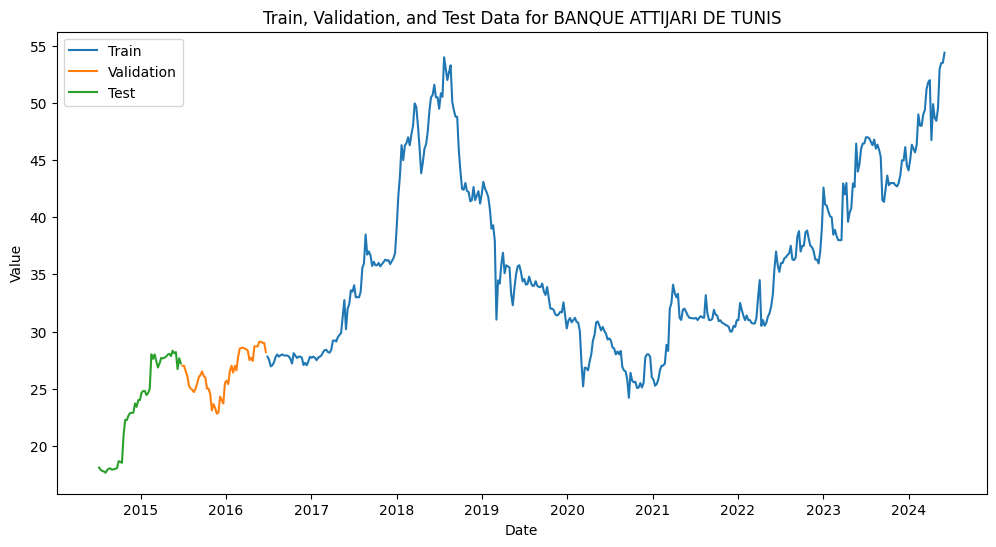

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.2774 - mean_absolute_error: 0.4874 - val_loss: 0.0288 - val_mean_absolute_error: 0.1637
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1664 - mean_absolute_error: 0.3652 - val_loss: 0.0026 - val_mean_absolute_error: 0.0426
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0519 - mean_absolute_error: 0.1780 - val_loss: 0.0292 - val_mean_absolute_error: 0.1686
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0145 - mean_absolute_error: 0.1059 - val_loss: 0.0226 - val_mean_absolute_error: 0.1476
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0102 - mean_absolute_error: 0.0841 - val_loss: 0.0125 - val_mean_absolute_error: 0.1081
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0084 - mean_absolute_error: 0.0763 - val_loss: 0.0168 - val_mean_absolute_error: 0.1271
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0068 - mean_absolute_error: 0.0711 - val_lo

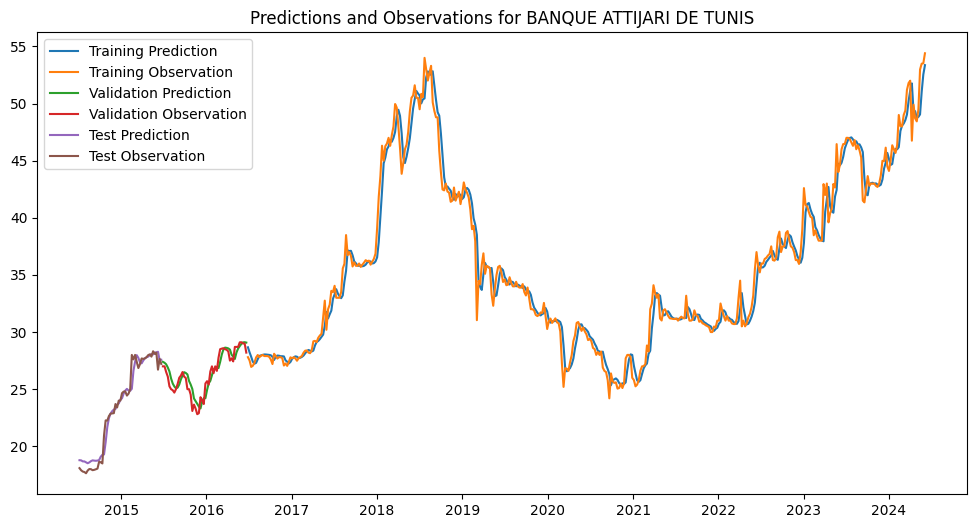

Starting recursive predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━

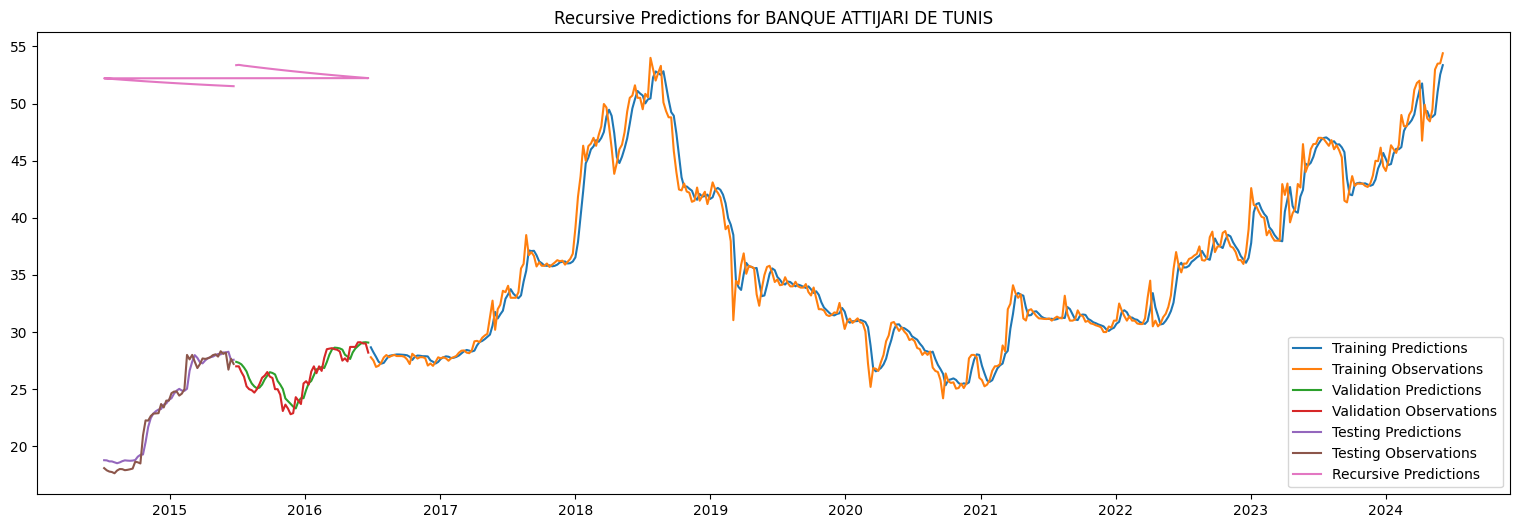

Training and plotting for TELNET HOLDING
Starting process for TELNET HOLDING...


C:\Users\Kahla\AppData\Local\Temp\ipykernel_11060\285995610.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


Splitting data into train, validation, and test sets...


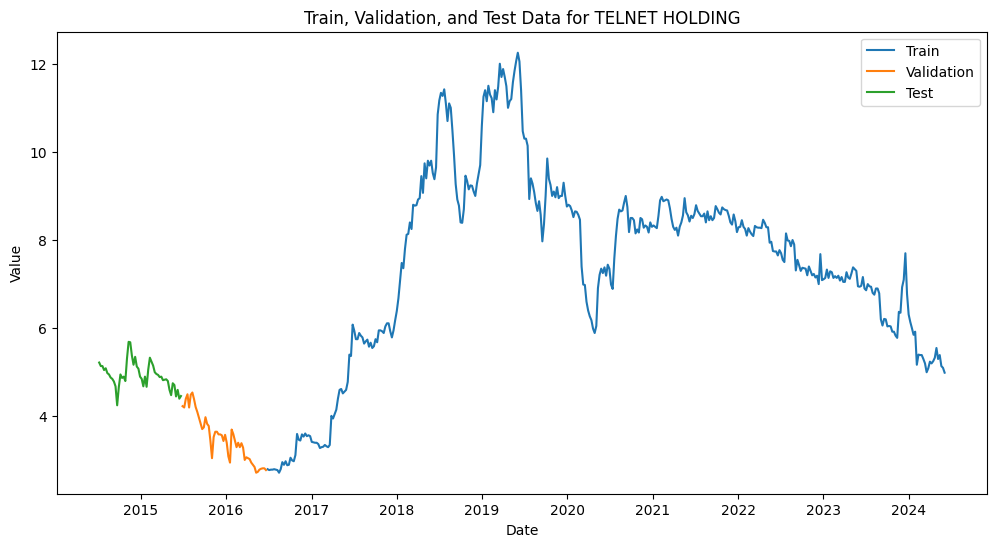

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.2889 - mean_absolute_error: 0.4852 - val_loss: 0.0024 - val_mean_absolute_error: 0.0410
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1492 - mean_absolute_error: 0.3373 - val_loss: 0.0160 - val_mean_absolute_error: 0.1207
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0272 - mean_absolute_error: 0.1360 - val_loss: 0.0612 - val_mean_absolute_error: 0.2458
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0125 - mean_absolute_error: 0.0890 - val_loss: 0.0235 - val_mean_absolute_error: 0.1501
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0081 - mean_absolute_error: 0.0709 - val_loss: 0.0204 - val_mean_absolute_error: 0.1407
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042 - mean_absolute_error: 0.0499 - val_loss: 0.0066 - val_mean_absolute_error: 0.0775
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0021 - mean_absolute_error: 0.0337 - val_

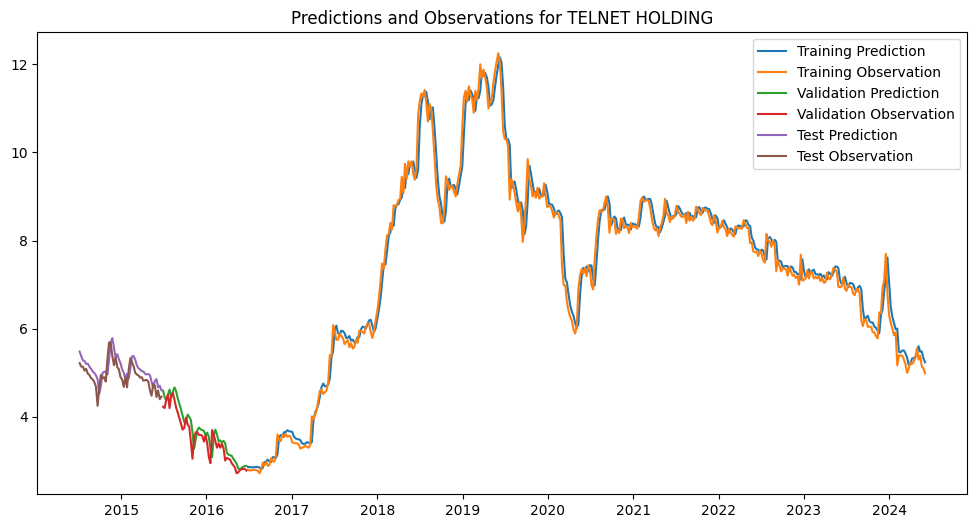

Starting recursive predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━

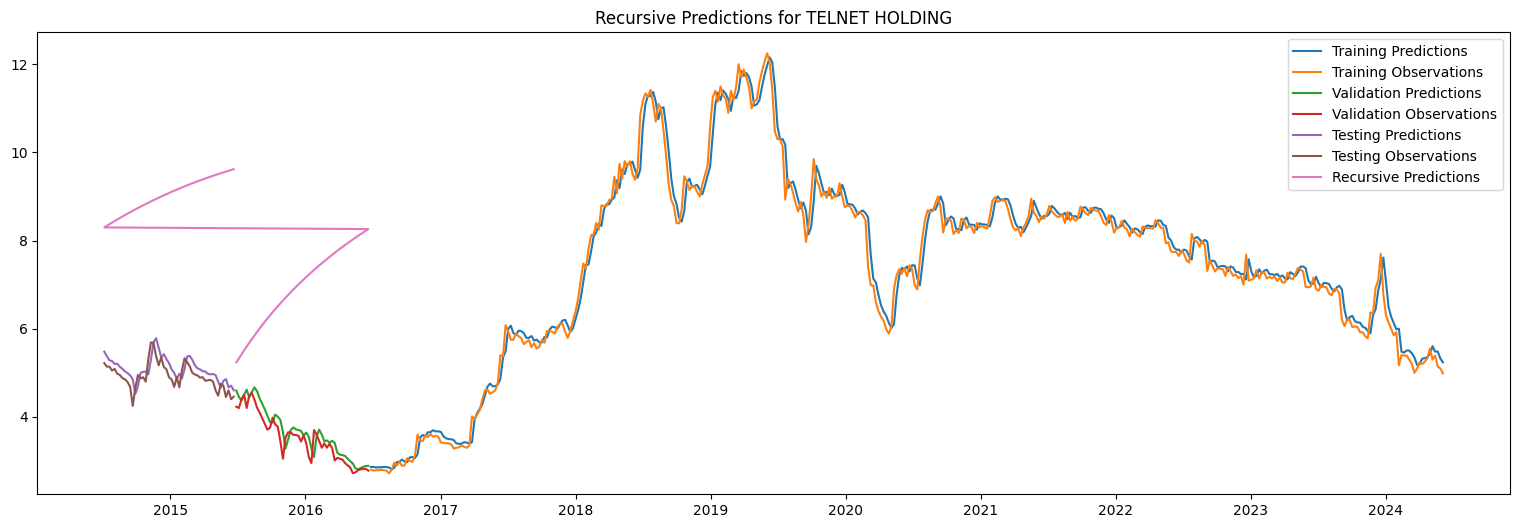

Training and plotting for TPR
Starting process for TPR...


C:\Users\Kahla\AppData\Local\Temp\ipykernel_11060\285995610.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


Splitting data into train, validation, and test sets...


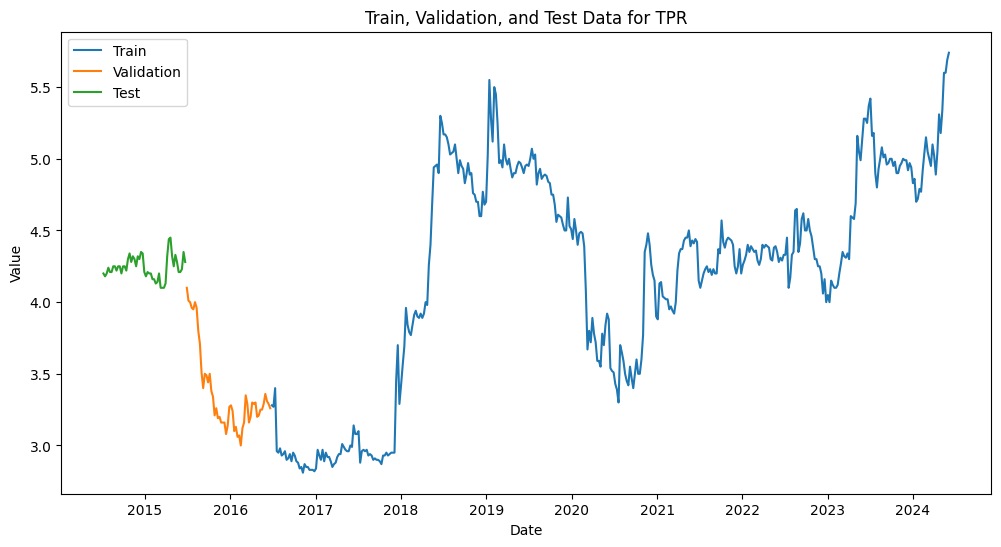

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.2447 - mean_absolute_error: 0.4313 - val_loss: 0.0091 - val_mean_absolute_error: 0.0631
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0904 - mean_absolute_error: 0.2540 - val_loss: 0.0325 - val_mean_absolute_error: 0.1742
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0217 - mean_absolute_error: 0.1196 - val_loss: 0.0324 - val_mean_absolute_error: 0.1752
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0149 - mean_absolute_error: 0.0969 - val_loss: 0.0163 - val_mean_absolute_error: 0.1213
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0105 - mean_absolute_error: 0.0792 - val_loss: 0.0144 - val_mean_absolute_error: 0.1155
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0074 - mean_absolute_error: 0.0650 - val_loss: 0.0065 - val_mean_absolute_error: 0.0748
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0042 - mean_absolute_error: 0.0489 - val_l

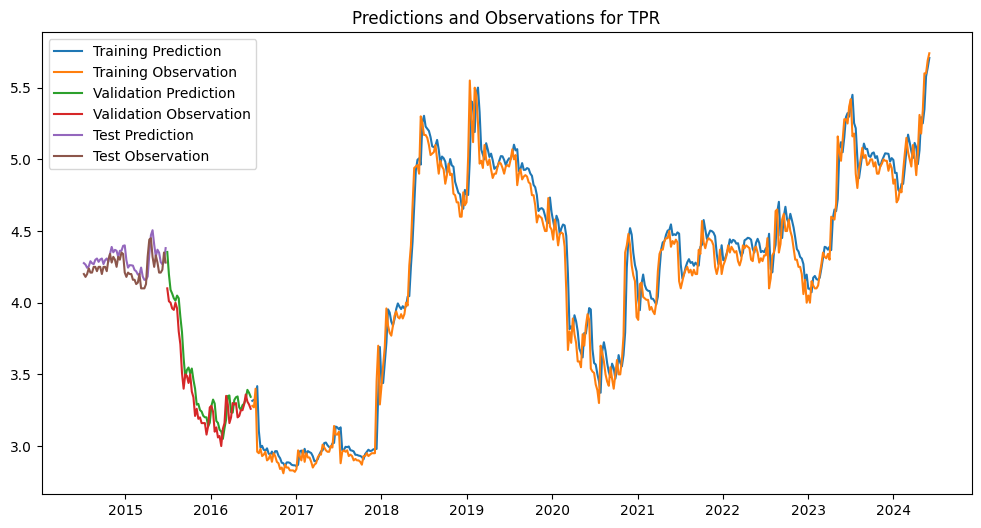

Starting recursive predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━

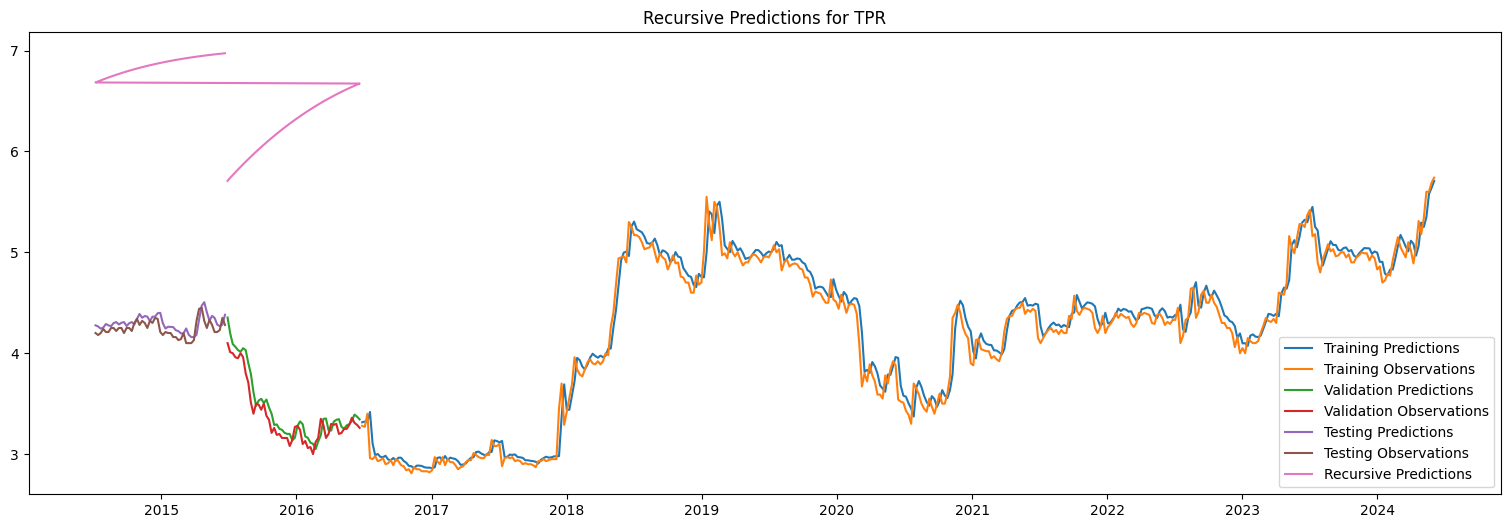

Training and plotting for UIB
Starting process for UIB...
Splitting data into train, validation, and test sets...


C:\Users\Kahla\AppData\Local\Temp\ipykernel_11060\285995610.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].apply(str_to_datetime)


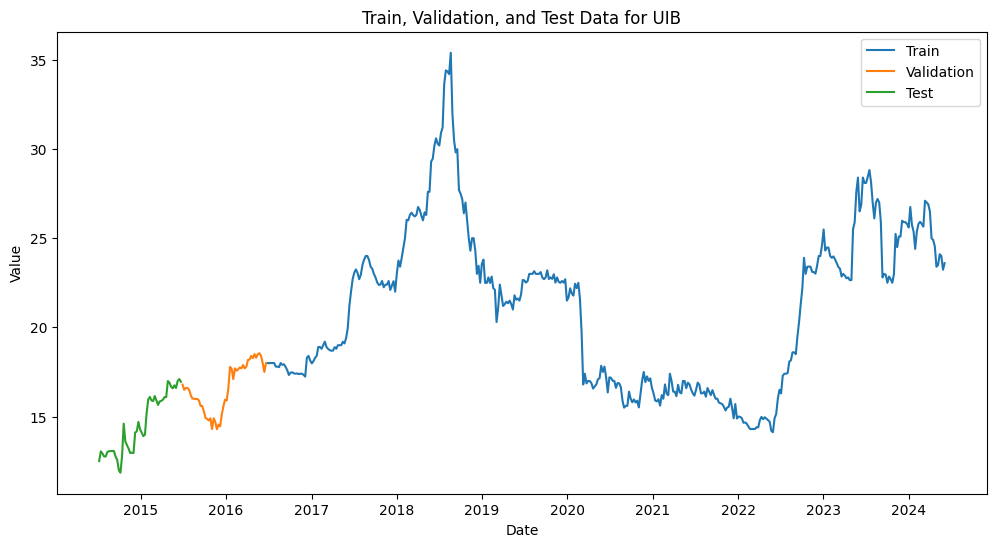

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.1777 - mean_absolute_error: 0.3763 - val_loss: 0.0227 - val_mean_absolute_error: 0.1409
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1069 - mean_absolute_error: 0.2799 - val_loss: 0.0034 - val_mean_absolute_error: 0.0490
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0470 - mean_absolute_error: 0.1621 - val_loss: 0.0190 - val_mean_absolute_error: 0.1336
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0128 - mean_absolute_error: 0.0930 - val_loss: 0.0139 - val_mean_absolute_error: 0.1133
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0097 - mean_absolute_error: 0.0812 - val_loss: 0.0095 - val_mean_absolute_error: 0.0927
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0074 - mean_absolute_error: 0.0695 - val_loss: 0.0072 - val_mean_absolute_error: 0.0802
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0048 - mean_absolute_error: 0.0555 - val_l

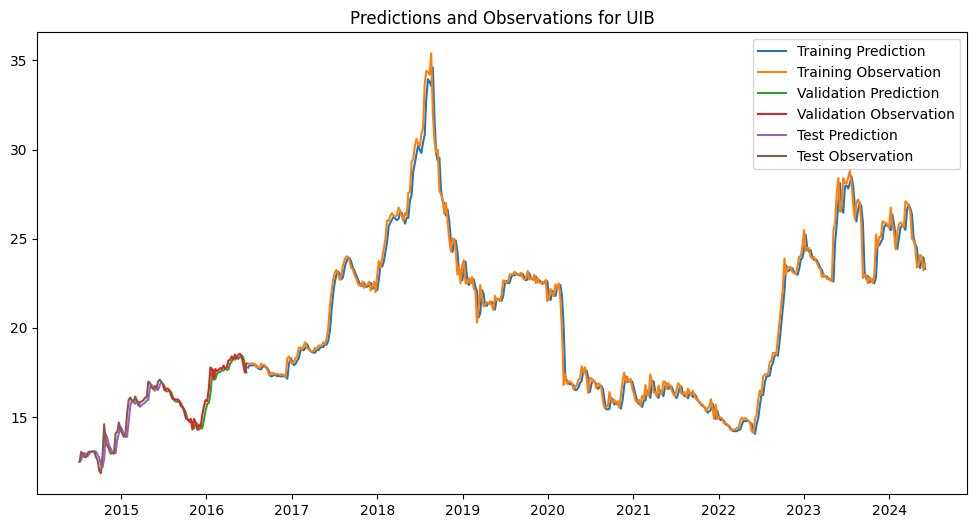

Starting recursive predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━

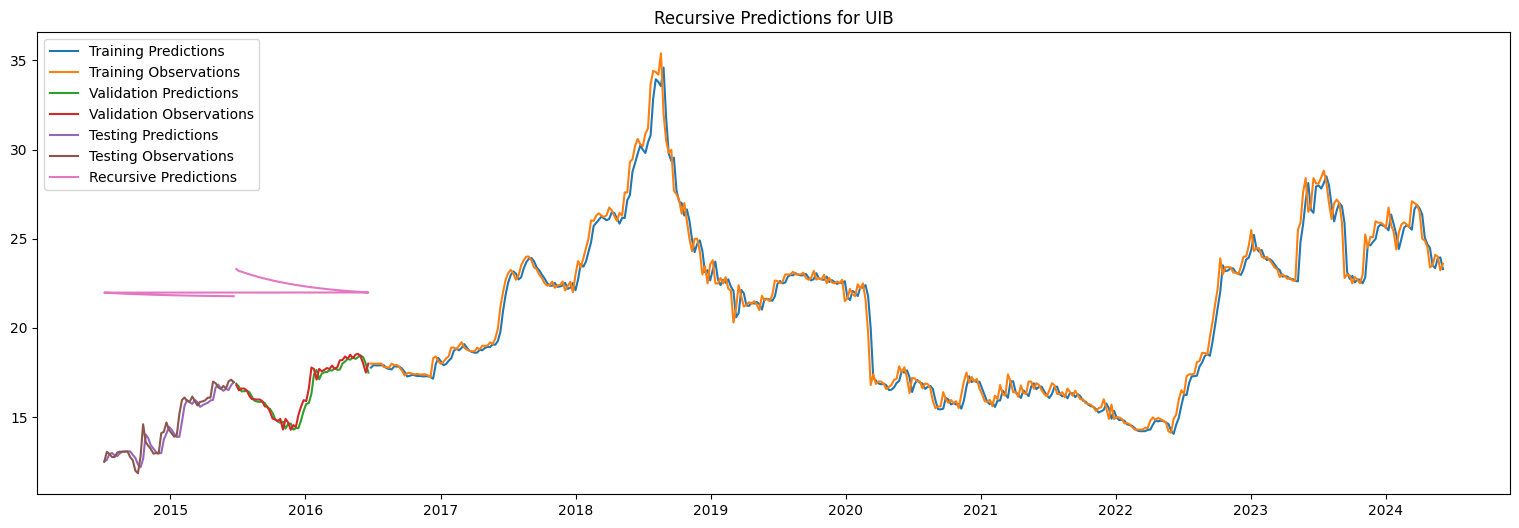

In [8]:
# Apply the model for each company
for company in companies:
    company_data = data_filtered[data_filtered['companyName'] == company]
    if not company_data.empty:
        print(f'Training and plotting for {company}')
        train_and_plot_model(company_data, company)
    else:
        print(f'No data available for {company}')